<a href="https://colab.research.google.com/github/spour/DeepExplain/blob/master/clean_checking_model_structures_sept1_generate_fakies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install simdna==0.4.2 --no-deps
# !pip install simdna-dragonn==0.1 --no-deps
!pip install dragonn --no-deps
!pip install numpy keras tensorflow-gpu deeplift shapely matplotlib plotnine scikit-learn pydot_ng h5py seqdataloader simdna_dragonn abstention
!pip install shap
!pip install vizsequence

     |████████████████████████████████| 458.3 MB 11 kB/s 
     |████████████████████████████████| 107 kB 50.3 MB/s 
     |████████████████████████████████| 648 kB 54.1 MB/s 
     |████████████████████████████████| 64 kB 3.2 MB/s 
     |████████████████████████████████| 16.2 MB 108 kB/s 
     |████████████████████████████████| 233 kB 54.4 MB/s 
     |████████████████████████████████| 12.5 MB 139 kB/s 
     |████████████████████████████████| 10.3 MB 45.9 MB/s 
     |████████████████████████████████| 47 kB 5.2 MB/s 
     |████████████████████████████████| 23.9 MB 13 kB/s 
     |████████████████████████████████| 9.9 MB 21.7 MB/s 
     |████████████████████████████████| 41 kB 95 kB/s 
  Created wheel for deeplift: filename=deeplift-0.6.13.0-py3-none-any.whl size=36449 sha256=1f1aeb8a49a095d47fd6c768623abfc858207a324b0f7d75fae8b01dcd8015de
  Stored in directory: /root/.cache/pip/wheels/5f/0f/15/3cb70dbd2147a5c948da210c6a283d87ea19c8e8ecb941b21e
  Created wheel for deeptoolsintervals: filenam

     |████████████████████████████████| 356 kB 4.0 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491634 sha256=fe63ae77be649d2c05165d06935d82523c226a97defb7f11270c54208f59f6f9
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
  Created wheel for vizsequence: filename=vizsequence-0.1.1.0-py3-none-any.whl size=3251 sha256=4275f731ab5808c587136d14201d8f38a1144467128d89c14bd9701eb5961770
  Stored in directory: /root/.cache/pip/wheels/71/9f/f5/485628dc7615245c7fe9be63dbab7316b732778f54df676264
Successfully built vizsequence


In [1]:
import tensorflow as tf
from dragonn.simulations import * 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Activation, Flatten, Dense, Dropout
import tensorflow.keras as keras
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.metrics import CategoricalAccuracy, AUC
from tensorflow.keras.callbacks import EarlyStopping, History
import simdna.synthetic as synthetic
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import train_test_split
import tensorflow.keras.initializers as initializers
from tensorflow.keras.layers import AveragePooling1D
import shap
from vizsequence import viz_sequence
import gzip
from tensorflow.keras.layers import GlobalMaxPooling1D

In [2]:
import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


#shuffled background
from collections import defaultdict
from random import shuffle


# compile the dinucleotide edges
def prepare_edges(s):
    edges = defaultdict(list)
    for i in range(len(s) - 1):
        edges[tuple(s[i])].append(s[i + 1])
    return edges


def shuffle_edges(edges):
    # for each character, remove the last edge, shuffle, add edge back
    for char in edges:
        last_edge = edges[char][-1]
        edges[char] = edges[char][:-1]
        the_list = edges[char]
        shuffle(the_list)
        edges[char].append(last_edge)
    return edges


def traverse_edges(s, edges):
    generated = [s[0]]
    edges_queue_pointers = defaultdict(lambda: 0)
    for i in range(len(s) - 1):
        last_char = generated[-1]
        generated.append(edges[tuple(last_char)][edges_queue_pointers[tuple(last_char)]])
        edges_queue_pointers[tuple(last_char)] += 1
    if isinstance(generated[0], str):
        return "".join(generated)
    else:
        import numpy as np
        return np.asarray(generated)


def dinuc_shuffle(s):
    if isinstance(s, str):
        s = s.upper()
    return traverse_edges(s, shuffle_edges(prepare_edges(s)))


def onehot_dinuc_shuffle(s):
    s = np.squeeze(s)
    argmax_vals = "".join([str(x) for x in np.argmax(s, axis=-1)])
    shuffled_argmax_vals = [int(x) for x in traverse_edges(argmax_vals,
                            shuffle_edges(prepare_edges(argmax_vals)))]
    to_return = np.zeros_like(s)
    to_return[list(range(len(s))), shuffled_argmax_vals] = 1
    return to_return

shuffle_several_times = lambda s: np.array([onehot_dinuc_shuffle(s) for i in range(10)])

            
# onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in sequences])

In [3]:
! [[ ! -f sequences.simdata.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
! [[ ! -f test.txt.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelJson.json ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelJson.json
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelWeights.h5 ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelWeights.h5

keras_model_weights = "keras2_conv1d_record_5_model_PQzyq_modelWeights.h5"
keras_model_json = "keras2_conv1d_record_5_model_PQzyq_modelJson.json"

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)
import gzip 
data_filename = "sequences.simdata.gz"
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = [x.decode("utf-8").rstrip("\n") for x in test_ids_fh]
data = synthetic.read_simdata_file(data_filename, ids_to_load=ids_to_load)
onehot_data_premade = np.array([one_hot_encode_along_channel_axis(seq) for seq in data.sequences])
labels_premade = data.labels




--2021-09-05 19:18:05--  https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 629502 (615K) [application/octet-stream]
Saving to: ‘sequences.simdata.gz’

sequences.simdata.g 100%[===================>] 614.75K  --.-KB/s    in 0.08s   

2021-09-05 19:18:05 (7.48 MB/s) - ‘sequences.simdata.gz’ saved [629502/629502]

--2021-09-05 19:18:05--  https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (r

In [5]:
print(onehot_data_premade.shape)
!zcat sequences.simdata | head

(800, 200, 4)
seqName	sequence	embeddings	task1	task2	task3
empty_1732	AGCTCTTTTGGCGGACCGAGTTCGTCGGACTTTCGCTAAATTGACCATTAACAGGAGGATACCCGGGTGTCTCGGGAAGGTCGTAATACGGTAATTACGGATGTGAGAGCGCACACATCCTTTGGATGATACATGATCTCGCCGTATATGGCCTAGGTCAAAAGGACAGTCTCGCTAATCGCAATAATGCAGCTAACCGA		0	0	0
gata_only_1527	TGCAGATAAGAACTTTGGGAATATGGTAGGAAAAACCCCTGAAGTGAGATCCAAAAAATATAGACTGGCGCGGTGGCAATGCCCTTGTTAATGCTGGGAATCAAAAAATCGAAACTCTCAGCAGATAAGATATGCAGACCTGCTCGTGGAGACAAAAAGTATTGTTACTGCGTAAACCATTAGTACGTTGCCGAGTACCG	pos-120_GATA_disc1-GCAGATAAGA,pos-1_GATA_disc1-GCAGATAAGA	0	1	0
gata_tal1_62	AGATTATAGGCCCTCCACCAGATAAGATATAGCGTTCGAGGGTCAGAAGGTAGTTCTGAAGATCTCTTCATTGTGAAAGGCCTCATATGATGAGCTTCTCCATTCTCAGCTGACAGGCAAAACAATTGATCAGCGCTTAGGCGCCAGATGTTTACTCCCGTTAAGTCAACTTAGCTGTGTTCGTCAAATCCGCAACGCGG	pos-17_GATA_disc1-CCAGATAAGA,pos-139_TAL1_known1-GGCGCCAGATGTTTAC	1	1	1
empty_1289	TTTGGGCGCGGAAGAAGTCGCTCGCCTTTCTGTACTTGAAAATGATTACATGTAAGGATGTAACTCAATCGCAACATTGTCATTGGGTTCCATCGCCCTAGCGGTAGTAGGTTTTACCTCCAACTTGACAACCCTTCGTAAATA

In [36]:
#for premade

model1 = Sequential()
model1.add(Conv1D(filters=50, kernel_size=(11), padding='valid', input_shape=onehot_data_premade.shape[1::], 
                  kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg')))
# model1.add(BatchNormalization())
model1.add(Activation('relu'))
# model1.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
model1.add(Conv1D(filters=50, kernel_size=(11), padding='valid',  
                  kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg')))
model1.add(Activation('relu'))
model1.add(AveragePooling1D(pool_size=(180,), strides=(180,)))
model1.add(Flatten())
model1.add(Dense(50, kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg'))) #there are three classes therefore 3 possibilities
model1.add(Activation("relu"))
model1.add(Dropout(0.5))
model1.add(Dense(3, kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg')))
model1.add(Activation("sigmoid"))

In [37]:

X_train_premade, X_test_premade, y_train_premade, y_test_premade = train_test_split(onehot_data_premade, labels_premade, test_size=0.33, random_state=42, stratify = labels_premade)


model1.compile(optimizer='adam',
                               loss='binary_crossentropy',
                               metrics=[tf.keras.metrics.BinaryCrossentropy(),
                                        tf.keras.metrics.AUC(curve='ROC'),
                                        tf.keras.metrics.AUC(curve='PR')])

model1.fit(x=X_train_premade,
                                  y=y_train_premade,
                                  batch_size=16,
                                  epochs=60, # 100
                # callbacks=[EarlyStopping(patience=7, monitor='val_loss'),   # If val_loss doesn't decrease after 3 epochs, stop training
                #                   History()],
                validation_split = 0.1)


model1.evaluate(X_test_premade, y_test_premade)

Train on 482 samples, validate on 54 samples
Epoch 1/60
482/482 [==============================] - 1s 2ms/sample - loss: 0.6742 - binary_crossentropy: 0.6742 - auc_6: 0.5973 - auc_7: 0.5336 - val_loss: 0.6625 - val_binary_crossentropy: 0.6625 - val_auc_6: 0.5835 - val_auc_7: 0.3983
Epoch 2/60
482/482 [==============================] - 1s 1ms/sample - loss: 0.6717 - binary_crossentropy: 0.6717 - auc_6: 0.6085 - auc_7: 0.5290 - val_loss: 0.6638 - val_binary_crossentropy: 0.6638 - val_auc_6: 0.5931 - val_auc_7: 0.3868
Epoch 3/60
482/482 [==============================] - 1s 1ms/sample - loss: 0.6671 - binary_crossentropy: 0.6671 - auc_6: 0.6138 - auc_7: 0.5289 - val_loss: 0.6656 - val_binary_crossentropy: 0.6656 - val_auc_6: 0.6105 - val_auc_7: 0.4239
Epoch 4/60
482/482 [==============================] - 1s 1ms/sample - loss: 0.6675 - binary_crossentropy: 0.6675 - auc_6: 0.6103 - auc_7: 0.5416 - val_loss: 0.6604 - val_binary_crossentropy: 0.6604 - val_auc_6: 0.6152 - val_auc_7: 0.4259
Epo

[0.18180306571902652, 0.18180308, 0.9826523, 0.97795856]

In [38]:
model1.evaluate(X_test_premade, y_test_premade)
# print(X_test_premade.shape)
# print(X_train_premade.shape)

[0.18180306571902652, 0.18180308, 0.9826523, 0.97795856]

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 190, 50)           2250      
_________________________________________________________________
activation_10 (Activation)   (None, 190, 50)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 180, 50)           27550     
_________________________________________________________________
activation_11 (Activation)   (None, 180, 50)           0         
_________________________________________________________________
average_pooling1d_2 (Average (None, 1, 50)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)               

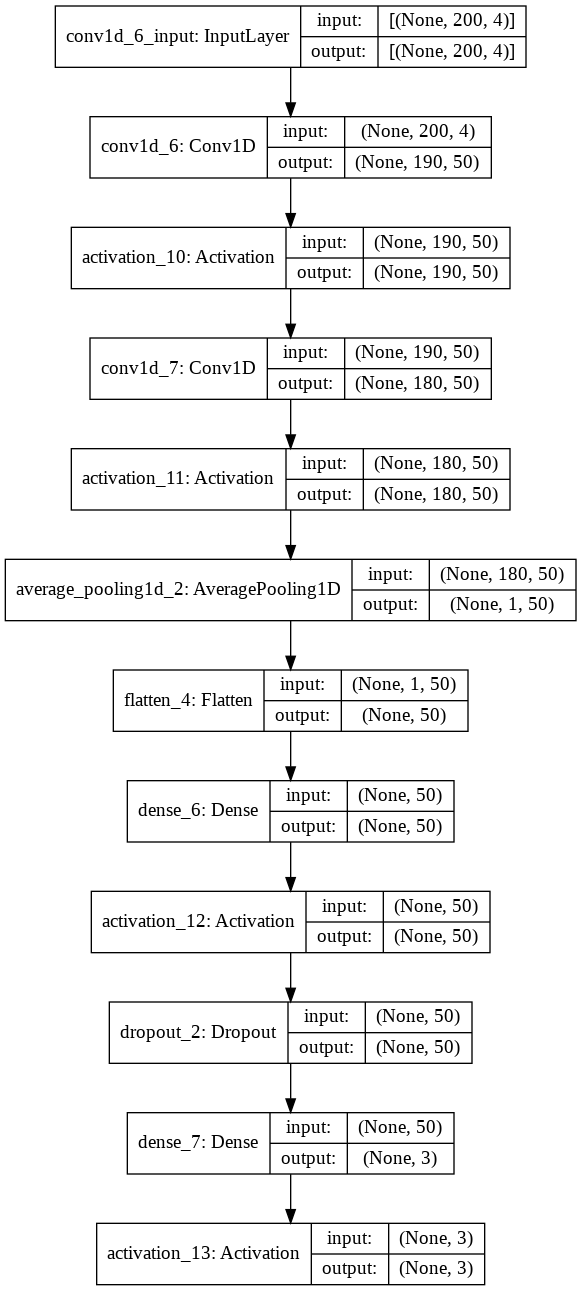

In [39]:
model1.summary()
from keras.utils.vis_utils import plot_model
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# !pip uninstall matplotlib
# !pip install matplotlib

In [10]:
# print(seqs_to_explain.shape)
# print(np.sum(raw_shap_explanations,axis=-1)[:,:,None].shape)
# print(raw_shap_explanations.shape)

NameError: ignored

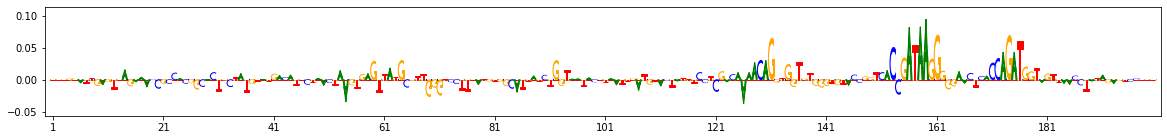

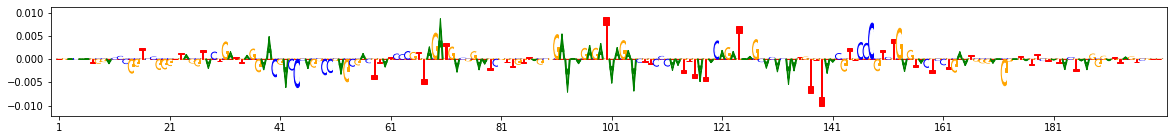

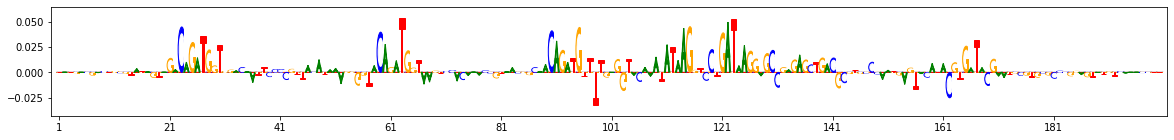

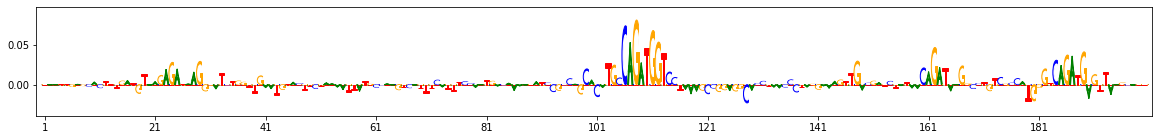

In [12]:
import shap
import matplotlib.pyplot as plt

from vizsequence import viz_sequence
seqs_to_explain = onehot_data_premade[[0,1,3,9]] #these three are positive for task 0
dinuc_shuff_explainer = shap.DeepExplainer((model1.input, model1.output[:,0]), shuffle_several_times)
raw_shap_explanations = dinuc_shuff_explainer.shap_values(seqs_to_explain, check_additivity=False)

#project the importance at each position onto the base that's actually present
dinuc_shuff_explanations = np.sum(raw_shap_explanations,axis=-1)[:,:,None]*seqs_to_explain
for dinuc_shuff_explanation in dinuc_shuff_explanations:
    viz_sequence.plot_weights(dinuc_shuff_explanation, subticks_frequency=20)

mine multi


In [50]:
#multi
data = simulations.simulate_multi_motif_embedding(
    motif_names = ["SIX5_known1", "CTCF_known1", "ZNF143_known2"],
    seq_length = 300,
    min_num_motifs = 1,
    max_num_motifs=3,
    num_seqs = 5000, 
    GC_fraction=0.4,
)
mm_sequences = data[0]
mm_labels = data[1]


<function tuple.count>

SyntaxError: ignored

In [15]:
simulations.simulate_single_motif_detection()

(array(['ATTACCGTAATCTACTATTAAGTCACAACCAAACAATGGATTACTTTCTGCGTTGGAATCAGTGCCGTGCCAATTGCAGTTGTAGTGCAGTATTTTTGGCATTCCCATAATGCACTGTTTATGAAATAAGCAAGAATCCCACCAATGAGTAAATATGGATTGAGCGCGAATTCTCTTCAATATTGATTTGCCAGCAAGACCTTAACTTCAGTTCTGCTATAATATGTCCATGTTAGAAATTTCGTCGAAATGTCATTAGAATAATCAAATATCTTAACAGAATAGCCATTTAAGTGGGAGCAAATCGGGCGCCACTTGGGGGCACTCGATCTAGTATATTTCAGTATATACTTTTTGACATGAATTGGTCCCAAGCGACAAATCCGAAGGGCGTACCACGTTAGAAGTATTCGTCTTGTTTGAAAGTAGTCGATATTGATTATTGTCTTCTCACATTAGCAAATAACAGGTAAGAGAGTTTGCTTGCAATATGTTTAGGC',
        'ATAATGCGTAGTTAGAGATTCATTTATGCCTTAGATCTTGAGAATCTATTCACCAAAGTAATTTGCTAGACCCAATCGATCGTTATTCCGTCTTATAAGACACTTAATAAAAAGTGTGCGTGAATGCGGGACCATCGTTTTATATTTAATCCTAGCACTTAGATAACTCATTTCCAGCCTTGAGCTTTTGTTAACGACGATGCACCTGGATCCATCTTTTTTTAGGTTTTCTGCCTGAAGGTACTAAGAAAGGAATGATACTTATGTTCGGTTTTTAATTGCCTTGATCAAGAACTTTGGGGGTTCGCCGGGTAGTTGCCTTGTTTCCTCTCCCACCAAATGATAGTGCTTTCCCATAATGCAATGAGTGGCTTAGCGAAACTTTGACGAGTATACTAGCTTACTGATCCATGTTAGCTTAATCAAGGTGGACAGAACCCGATGGACGGTTCCCAAAAGTGGAAGTCAACGAAGTCGGA

In [16]:
onehot_data_mm = np.array([one_hot_encode_along_channel_axis(seq) for seq in mm_sequences])

In [17]:
X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(onehot_data_mm, mm_labels, test_size=0.33, random_state=42, stratify = mm_labels)

In [ ]:
X_train_mm.shape

In [18]:
model1 = Sequential()
model1.add(Conv1D(filters=50, kernel_size=(11), padding='valid', input_shape=onehot_data_mm.shape[1::], 
                  kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg')))
# model1.add(BatchNormalization())
model1.add(Activation('relu'))
# model1.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
model1.add(Conv1D(filters=50, kernel_size=(11), padding='valid',  
                  kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg')))
model1.add(Activation('relu'))
model1.add(AveragePooling1D(pool_size=(180,), strides=(180,)))
model1.add(Flatten())
model1.add(Dense(5, kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg'))) #there are three classes therefore 3 possibilities
model1.add(Activation("relu"))
model1.add(Dropout(0.5))
model1.add(Dense(3, kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg')))
model1.add(Activation("sigmoid"))

In [19]:

model1.compile(optimizer=tf.keras.optimizers.Adam(0.00001),
                               loss='binary_crossentropy',
                               metrics=[tf.keras.metrics.BinaryCrossentropy(),
                                        tf.keras.metrics.AUC(curve='ROC'),
                                        tf.keras.metrics.AUC(curve='PR')])

model1.fit(x=X_train_mm,
                                  y=y_train_mm,
                                  batch_size=16,
                                  epochs=100,
                # callbacks=[EarlyStopping(patience=7, monitor='val_loss'),   # If val_loss doesn't decrease after 3 epochs, stop training
                #                   History()],
                validation_split = 0.1)


model1.evaluate(X_test_mm, y_test_mm)

Train on 3015 samples, validate on 335 samples
Epoch 1/100
3015/3015 [==============================] - 10s 3ms/sample - loss: 0.6876 - binary_crossentropy: 0.6876 - auc_4: 0.5069 - auc_5: 0.6777 - val_loss: 0.6873 - val_binary_crossentropy: 0.6873 - val_auc_4: 0.4971 - val_auc_5: 0.6603
Epoch 2/100
3015/3015 [==============================] - 10s 3ms/sample - loss: 0.6855 - binary_crossentropy: 0.6855 - auc_4: 0.5109 - auc_5: 0.6783 - val_loss: 0.6862 - val_binary_crossentropy: 0.6862 - val_auc_4: 0.4925 - val_auc_5: 0.6564
Epoch 3/100
3015/3015 [==============================] - 10s 3ms/sample - loss: 0.6861 - binary_crossentropy: 0.6861 - auc_4: 0.5037 - auc_5: 0.6740 - val_loss: 0.6858 - val_binary_crossentropy: 0.6858 - val_auc_4: 0.4905 - val_auc_5: 0.6514
Epoch 4/100
3015/3015 [==============================] - 10s 3ms/sample - loss: 0.6851 - binary_crossentropy: 0.6851 - auc_4: 0.5077 - auc_5: 0.6774 - val_loss: 0.6855 - val_binary_crossentropy: 0.6855 - val_auc_4: 0.5025 - val

KeyboardInterrupt: ignored

monomotif


In [20]:
simulate_single_motif_detection_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 500,
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

In [21]:
simulation_data = get_simulation_data("simulate_single_motif_detection",
                                      simulate_single_motif_detection_parameters,
                                      validation_set_size=1000, test_set_size=1000)

In [22]:
X_train = simulation_data.X_train.squeeze(1)
y_train = simulation_data.y_train
y_test = simulation_data.y_test
y_valid = simulation_data.y_valid
X_test = simulation_data.X_test.squeeze(1)
X_valid = simulation_data.X_valid.squeeze(1)

In [ ]:
X_train.shape[1]

In [24]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import GlobalAveragePooling1D, MaxPooling1D

class GlobalMaxPooling1D_(GlobalMaxPooling1D):
    def call(self, inputs):
        steps_axis = 1 if self.data_format == 'channels_last' else 2
        return K.max(inputs, axis=steps_axis, keepdims=True)
    
    
class GlobalAveragePooling1D_(GlobalAveragePooling1D):
    def call(self, inputs, mask=None):
        steps_axis = 1 if self.data_format == 'channels_last' else 2
        return K.mean(inputs, axis=steps_axis, keepdims=True)

# max_pool1 = MaxPooling1D(pool_size=step_size, strides=1)(x)
# max_pool1 = Lambda(lambda s: backend.squeeze(s, axis=1))(max_pool1)

model = Sequential([Conv1D(filters=16, kernel_size=15, activation='relu', input_shape=X_train.shape[1:]),
                    MaxPooling1D(486),
                    Flatten(),
                    Dense(units=1),
                    Activation('sigmoid')
                   ])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, 
                    y_train, 
                    validation_split=0.2,  # use 20% of the data as the validation set
                    # callbacks=[EarlyStopping(patience=3),   # If val_loss doesn't decrease after 3 epochs, stop training
                    #            History()],
                    batch_size=512,  # On every optimization step, we use 512 examples from the training data
                    epochs=20) 

Train on 14400 samples, validate on 3600 samples
Epoch 1/20
14400/14400 [==============================] - 4s 254us/sample - loss: 0.7887 - accuracy: 0.5048 - val_loss: 0.6972 - val_accuracy: 0.5078
Epoch 2/20
14400/14400 [==============================] - 3s 237us/sample - loss: 0.6975 - accuracy: 0.4974 - val_loss: 0.6956 - val_accuracy: 0.4994
Epoch 3/20
14400/14400 [==============================] - 3s 237us/sample - loss: 0.6932 - accuracy: 0.5078 - val_loss: 0.6942 - val_accuracy: 0.4992
Epoch 4/20
14400/14400 [==============================] - 3s 235us/sample - loss: 0.6917 - accuracy: 0.5204 - val_loss: 0.6934 - val_accuracy: 0.4989
Epoch 5/20
14400/14400 [==============================] - 3s 233us/sample - loss: 0.6896 - accuracy: 0.5358 - val_loss: 0.6913 - val_accuracy: 0.5158
Epoch 6/20
14400/14400 [==============================] - 3s 238us/sample - loss: 0.6848 - accuracy: 0.5709 - val_loss: 0.6845 - val_accuracy: 0.5569
Epoch 7/20
14400/14400 [===========================

In [26]:
model.evaluate(X_test, y_test)
# y_test[0:10]

[0.37575229978561403, 0.914]

In [27]:
# from dragonn.utils import fasta_from_onehot
# fasta_from_onehot(simulation_data.X_train)
#should be (3, 200, 4), (3, 200, 1)
seqs_to_explain = X_train[[0,3,9]]
print(seqs_to_explain.shape)
print(np.expand_dims(np.sum(raw_shap_explanations,axis=-1)[:,:,None].squeeze(), -1).shape)


(3, 500, 4)
(4, 200, 1)


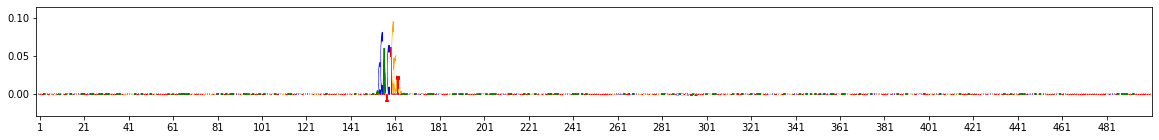

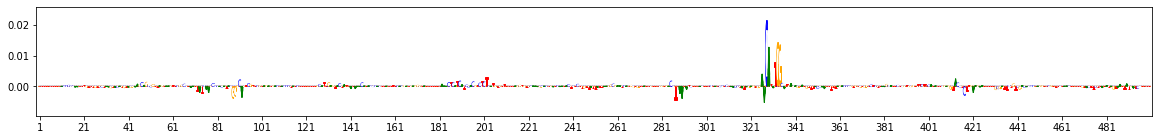

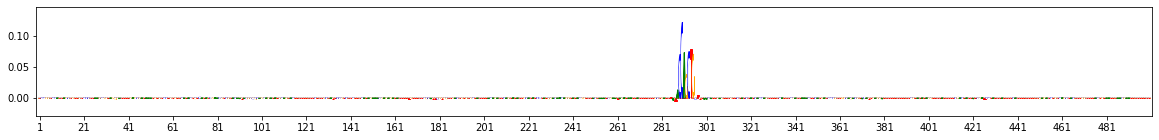

In [28]:
#solution 1 with problem with global maxpooling
import shap
import matplotlib.pyplot as plt
#weird error with global maxpooling (https://github.com/slundberg/shap/issues/559)
from vizsequence import viz_sequence
seqs_to_explain = X_test[[1,6,9]] #these three are positive for task 0
dinuc_shuff_explainer = shap.DeepExplainer((model.input, model.output[:,0]), shuffle_several_times)
raw_shap_explanations = dinuc_shuff_explainer.shap_values(seqs_to_explain, check_additivity=False)

#project the importance at each position onto the base that's actually present
dinuc_shuff_explanations = np.expand_dims(np.sum(raw_shap_explanations,axis=-1)[:,:,None].squeeze(), -1)*seqs_to_explain
for dinuc_shuff_explanation in dinuc_shuff_explanations:
    viz_sequence.plot_weights(dinuc_shuff_explanation, subticks_frequency=20)

In [29]:
#CONCISE
import numpy as np
import copy
from io import StringIO
import gzip

import matplotlib.pyplot as plt

import sklearn.preprocessing
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math

from collections import OrderedDict

from matplotlib import pyplot
from matplotlib.patches import PathPatch
from matplotlib.path import Path

from descartes.patch import Polygon, PolygonPath, PolygonPatch
from shapely.wkt import loads as load_wkt

from shapely import affinity
import re


def heatmap(w, vmin=None, vmax=None, diverge_color=False,
            ncol=1,
            plot_name=None, vocab=["A", "C", "G", "T"], figsize=(6, 2)):
    """Plot a heatmap from weight matrix w

    vmin, vmax = z axis range
    diverge_color = Should we use diverging colors?
    plot_name = plot_title
    vocab = vocabulary (corresponds to the first axis)
    """
    # Generate y and x values from the dimension lengths
    assert len(vocab) == w.shape[0]
    plt_y = np.arange(w.shape[0] + 1) + 0.5
    plt_x = np.arange(w.shape[1] + 1) - 0.5
    z_min = w.min()
    z_max = w.max()

    if vmin is None:
        vmin = z_min
    if vmax is None:
        vmax = z_max

    if diverge_color:
        color_map = plt.cm.RdBu
    else:
        color_map = plt.cm.Blues

    fig = plt.figure(figsize=figsize)
    # multiple axis
    if len(w.shape) == 3:
        #
        n_plots = w.shape[2]
        nrow = math.ceil(n_plots / ncol)
    else:
        n_plots = 1
        nrow = 1
        ncol = 1

    for i in range(n_plots):
        if len(w.shape) == 3:
            w_cur = w[:, :, i]
        else:
            w_cur = w
        ax = plt.subplot(nrow, ncol, i + 1)
        plt.tight_layout()
        im = ax.pcolormesh(plt_x, plt_y, w_cur, cmap=color_map,
                           vmin=vmin, vmax=vmax, edgecolors="white")
        ax.grid(False)
        ax.set_yticklabels([""] + vocab, minor=False)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_xticks(np.arange(w_cur.shape[1] + 1))
        ax.set_xlim(plt_x.min(), plt_x.max())
        ax.set_ylim(plt_y.min(), plt_y.max())

        # nice scale location:
        # http://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax)

        if plot_name is not None:
            if n_plots > 0:
                pln = plot_name + " {0}".format(i)
            else:
                pln = plot_name
            ax.set_title(pln)
        ax.set_aspect('equal')
    return fig


# -----------------------------------------------------------------------
#
#
# Code adoped from https://github.com/kundajelab/dragonn, (c) 2016 Kundaje Lab


def standardize_polygons_str(data_str):
    """Given a POLYGON string, standardize the coordinates to a 1x1 grid.
    Input : data_str (taken from above)
    Output: tuple of polygon objects
    """
    # find all of the polygons in the letter (for instance an A
    # needs to be constructed from 2 polygons)
    path_strs = re.findall("\(\(([^\)]+?)\)\)", data_str.strip())

    # convert the data into a numpy array
    polygons_data = []
    for path_str in path_strs:
        data = np.array([
            tuple(map(float, x.split())) for x in path_str.strip().split(",")])
        polygons_data.append(data)

    # standardize the coordinates
    min_coords = np.vstack([data.min(0) for data in polygons_data]).min(0)
    max_coords = np.vstack([data.max(0) for data in polygons_data]).max(0)
    for data in polygons_data:
        data[:, ] -= min_coords
        data[:, ] /= (max_coords - min_coords)

    polygons = []
    for data in polygons_data:
        polygons.append(load_wkt(
            "POLYGON((%s))" % ",".join(" ".join(map(str, x)) for x in data)))

    return tuple(polygons)


# ----------------------
import string

# Geometry taken from JTS TestBuilder Monospace font with fixed precision model
# of 1000.0

A = """MULTIPOLYGON (
((30.0781 64.2031, 19.6719 26.9062, 40.4844 26.9062, 30.0781 64.2031)),
((24.125 72.9062, 36.0781 72.9062, 58.4062 0, 48.1875 0, 42.8281 19, 17.2812 19, 12.0156 0, 1.8125 0, 24.125 72.9062))
)"""

A = """MULTIPOLYGON (
((24.7631 57.3346, 34.3963 57.3346, 52.391 -1.422, 44.1555 -1.422, 39.8363
  13.8905, 19.2476 13.8905, 15.0039 -1.422, 6.781 -1.422, 24.7631 57.3346)),
((29.5608 50.3205, 21.1742 20.2623, 37.9474 20.2623, 29.5608 50.3205))
)"""

B = """MULTIPOLYGON (((18.0156 34.8125, 18.0156 8.1094, 29.6875 8.1094, 33.6763 8.2969, 37.0488 8.8594, 39.8052 9.7969, 41.9453 11.1094, 43.5483 12.8525, 44.6934 15.082, 45.3804 17.7979, 45.6094 21, 45.3682 24.3262, 44.6445 27.1797, 43.4385 29.5605, 41.75 31.4688, 39.5488 32.9316, 36.8047 33.9766, 33.5176 34.6035, 29.6875 34.8125, 18.0156 34.8125), 
  (18.0156 64.7969, 18.0156 42.8281, 29.5 42.8281, 32.8169 42.999, 35.6426 43.5117, 37.9771 44.3662, 39.8203 45.5625, 41.2183 47.1396, 42.2168 49.1367, 42.8159 51.5537, 43.0156 54.3906, 42.8188 56.9565, 42.2285 59.1387, 41.2446 60.937, 39.8672 62.3516, 38.0386 63.4214, 35.7012 64.1855, 32.855 64.644, 29.5 64.7969, 18.0156 64.7969)), 
  ((8.1094 72.9062, 29.6875 72.9062, 34.9604 72.604, 39.5918 71.6973, 43.5815 70.186, 46.9297 68.0703, 49.5786 65.4019, 51.4707 62.2324, 52.606 58.562, 52.9844 54.3906, 52.7842 51.2236, 52.1836 48.4102, 51.1826 45.9502, 49.7812 43.8438, 47.9805 42.0947, 45.7812 40.707, 43.1836 39.6807, 40.1875 39.0156, 43.5801 38.228, 46.5859 36.9434, 49.2051 35.1616, 51.4375 32.8828, 53.2217 30.1831, 54.4961 27.1387, 55.2607 23.7495, 55.5156 20.0156, 55.1099 15.3657, 53.8926 11.3223, 52.9796 9.528, 51.8638 7.8853, 50.545 6.3942, 49.0234 5.0547, 45.3804 2.8433, 40.9434 1.2637, 35.7124 0.3159, 29.6875 0, 8.1094 0, 8.1094 72.9062)))"""

C = """POLYGON ((52.3906 2.5938, 48.5879 0.8418, 44.6797 -0.4141, 40.5996 -1.1699, 36.2812 -1.4219, 32.8754 -1.267, 29.6655 -0.8022, 26.6517 -0.0277, 23.834 1.0566, 21.2123 2.4508, 18.7866 4.1548, 16.557 6.1686, 14.5234 8.4922, 12.7089 11.0966, 11.1362 13.9526, 9.8055 17.0604, 8.7168 20.4199, 7.87 24.0311, 7.2651 27.894, 6.9022 32.0087, 6.7812 36.375, 6.903 40.7205, 7.2681 44.8193, 7.8766 48.6716, 8.7285 52.2773, 9.8239 55.6365, 11.1626 58.749, 12.7448 61.615, 14.5703 64.2344, 16.6134 66.5745, 18.8481 68.6025, 21.2745 70.3186, 23.8926 71.7227, 26.7023 72.8147, 29.7036 73.5947, 32.8966 74.0627, 36.2812 74.2188, 40.5996 73.9688, 44.6797 73.2188, 48.5879 71.9688, 52.3906 70.2188, 52.3906 60.1094, 48.6465 62.7383, 44.6328 64.6562, 40.4707 65.8281, 36.2812 66.2188, 31.7715 65.7549, 29.7437 65.175, 27.8672 64.3633, 26.1421 63.3196, 24.5684 62.0439, 23.146 60.5364, 21.875 58.7969, 19.7832 54.6123, 18.2891 49.4805, 17.3926 43.4014, 17.0938 36.375, 17.3926 29.376, 18.2891 23.3164, 19.7832 18.1963, 21.875 14.0156, 23.146 12.2761, 24.5684 10.7686, 26.1421 9.4929, 27.8672 8.4492, 29.7437 7.6375, 31.7715 7.0576, 36.2812 6.5938, 40.5352 6.9844, 44.7031 8.1562, 48.6875 10.0742, 52.3906 12.7031, 52.3906 2.5938))"""

D = """MULTIPOLYGON (
((21.4844 72.9062, 25.5227 72.7673, 29.2861 72.3506, 32.7747 71.656, 35.9883 70.6836, 38.927 69.4333, 41.5908 67.9053, 43.9797 66.0994, 46.0938 64.0156, 47.9468 61.6389, 49.5527 58.9541, 50.9116 55.9612, 52.0234 52.6602, 52.8882 49.051, 53.5059 45.1338, 53.8765 40.9084, 54 36.375, 53.8765 31.864, 53.5059 27.6592, 52.8882 23.7605, 52.0234 20.168, 50.9116 16.8816, 49.5527 13.9014, 47.9468 11.2273, 46.0938 8.8594, 43.9797 6.783, 41.5908 4.9834, 38.927 3.4607, 35.9883 2.2148, 32.7747 1.2458, 29.2861 0.5537, 25.5227 0.1384, 21.4844 0, 6.6875 0, 6.6875 72.9062, 21.4844 72.9062)),
((21.2969 8.1094, 27.0469 8.4922, 31.8594 9.6406, 33.9141 10.502, 35.7344 11.5547, 37.3203 12.7988, 38.6719 14.2344, 39.8291 15.9202, 40.832 17.915, 42.375 22.832, 43.3008 28.9854, 43.6094 36.375, 43.3027 43.833, 42.3828 50.0352, 40.8496 54.9814, 39.853 56.9836, 38.7031 58.6719, 37.3579 60.1074, 35.7754 61.3516, 33.9556 62.4043, 31.8984 63.2656, 27.0723 64.4141, 21.2969 64.7969, 16.6094 64.7969, 16.6094 8.1094, 21.2969 8.1094)))"""

E = """POLYGON ((9.625 72.9062, 52.875 72.9062, 52.875 64.5938, 19.4844 64.5938, 19.4844 43.0156, 51.4219 43.0156, 51.4219 34.7188, 19.4844 34.7188, 19.4844 8.2969, 53.8125 8.2969, 53.8125 0, 9.625 0, 9.625 72.9062))"""

F = """POLYGON ((11.375 72.9062, 54.2969 72.9062, 54.2969 64.5938, 21.2969 64.5938, 21.2969 43.1094, 51.2188 43.1094, 51.2188 34.8125, 21.2969 34.8125, 21.2969 0, 11.375 0, 11.375 72.9062))"""

G = """POLYGON ((53.9062 6, 51.8672 4.2827, 49.7031 2.7871, 47.4141 1.5132, 45 0.4609, 42.4727 -0.3628, 39.8438 -0.9512, 34.2812 -1.4219, 30.9088 -1.2666, 27.729 -0.8008, 24.7418 -0.0244, 21.9473 1.0625, 19.3453 2.46, 16.936 4.168, 14.7194 6.1865, 12.6953 8.5156, 10.8881 11.1248, 9.3218 13.9834, 7.9965 17.0916, 6.9121 20.4492, 6.0687 24.0564, 5.4663 27.9131, 5.1049 32.0193, 4.9844 36.375, 5.1064 40.7205, 5.4727 44.8193, 6.083 48.6716, 6.9375 52.2773, 8.0361 55.6365, 9.3789 58.749, 10.9658 61.615, 12.7969 64.2344, 14.8452 66.5745, 17.084 68.6025, 19.5132 70.3186, 22.1328 71.7227, 24.9429 72.8147, 27.9434 73.5947, 31.1343 74.0627, 34.5156 74.2188, 39.0117 73.8945, 43.3125 72.9219, 47.4414 71.293, 51.4219 69, 51.4219 58.8906, 47.418 62.1504, 43.3125 64.4297, 39.0352 65.7715, 34.5156 66.2188, 30.0107 65.7529, 27.9832 65.1707, 26.1055 64.3555, 24.3777 63.3074, 22.7998 62.0264, 21.3718 60.5125, 20.0938 58.7656, 17.9883 54.5713, 16.4844 49.4414, 15.582 43.376, 15.2812 36.375, 15.5728 29.2744, 16.4473 23.1602, 17.9048 18.0322, 19.9453 13.8906, 21.1896 12.1804, 22.5903 10.6982, 24.1476 9.4441, 25.8613 8.418, 27.7316 7.6199, 29.7583 7.0498, 34.2812 6.5938, 37.3477 6.7832, 40.0156 7.3516, 42.3672 8.3223, 44.4844 9.7188, 44.4844 29.2969, 33.8906 29.2969, 33.8906 37.4062, 53.9062 37.4062, 53.9062 6))"""

H = """POLYGON ((6.6875 72.9062, 16.6094 72.9062, 16.6094 43.0156, 43.6094 43.0156, 43.6094 72.9062, 53.5156 72.9062, 53.5156 0, 43.6094 0, 43.6094 34.7188, 16.6094 34.7188, 16.6094 0, 6.6875 0, 6.6875 72.9062))"""

I = """POLYGON ((9.8125 72.9062, 50.2969 72.9062, 50.2969 64.5938, 35.0156 64.5938, 35.0156 8.2969, 50.2969 8.2969, 50.2969 0, 9.8125 0, 9.8125 8.2969, 25.0938 8.2969, 25.0938 64.5938, 9.8125 64.5938, 9.8125 72.9062))"""


J = """POLYGON ((5.3281 2.9844, 5.3281 14.5, 9.8398 11.041, 14.5 8.5703, 19.3203 7.0879, 21.7949 6.7173, 24.3125 6.5938, 27.5405 6.8213, 30.2402 7.5039, 32.4116 8.6416, 34.0547 10.2344, 35.2612 12.4463, 36.123 15.4414, 36.6401 19.2197, 36.8125 23.7812, 36.8125 64.5938, 18.2188 64.5938, 18.2188 72.9062, 46.6875 72.9062, 46.6875 23.7812, 46.3652 17.4014, 45.3984 12.0273, 43.7871 7.6592, 42.7397 5.8523, 41.5312 4.2969, 40.1343 2.9565, 38.5215 1.7949, 36.6929 0.812, 34.6484 0.0078, 29.9121 -1.0645, 24.3125 -1.4219, 19.6387 -1.1523, 14.9922 -0.3438, 10.2598 1.0273, 5.3281 2.9844))"""

K = """POLYGON ((6.6875 72.9062, 16.6094 72.9062, 16.6094 40.4844, 47.4062 72.9062, 58.9844 72.9062, 30.6094 43.1094, 59.8125 0, 47.9062 0, 24.125 36.5312, 16.6094 28.5156, 16.6094 0, 6.6875 0, 6.6875 72.9062))"""

L = """POLYGON ((10.5 72.9062, 20.4062 72.9062, 20.4062 8.2969, 55.6094 8.2969, 55.6094 0, 10.5 0, 10.5 72.9062))"""

M = """POLYGON ((4.2031 72.9062, 17.3906 72.9062, 29.9844 35.7969, 42.6719 72.9062, 55.9062 72.9062, 55.9062 0, 46.7812 0, 46.7812 64.4062, 33.7969 25.9844, 26.3125 25.9844, 13.2812 64.4062, 13.2812 0, 4.2031 0, 4.2031 72.9062))"""

N = """POLYGON ((6.7812 72.9062, 19.2812 72.9062, 43.8906 12.8906, 43.8906 72.9062, 53.4219 72.9062, 53.4219 0, 40.9219 0, 16.3125 60.0156, 16.3125 0, 6.7812 0, 6.7812 72.9062))"""

O = """MULTIPOLYGON (
((44.1875 36.375, 43.9814 43.833, 43.3633 50.1445, 42.333 55.3096, 40.8906 59.3281, 38.9785 62.3428, 36.5391 64.4961, 35.1216 65.2498, 33.5723 65.7881, 30.0781 66.2188, 26.6045 65.7881, 23.6523 64.4961, 21.2217 62.3428, 19.3125 59.3281, 17.8701 55.3096, 16.8398 50.1445, 16.2217 43.833, 16.0156 36.375, 16.2217 28.938, 16.8398 22.6426, 17.8701 17.4888, 19.3125 13.4766, 21.2217 10.4653, 23.6523 8.3145, 26.6045 7.0239, 30.0781 6.5938, 33.5723 7.0225, 36.5391 8.3086, 38.9785 10.4521, 40.8906 13.4531, 42.333 17.458, 43.3633 22.6133, 43.9814 28.9189, 44.1875 36.375)), 
  ((54.5 36.375, 54.123 27.4561, 52.9922 19.7461, 52.144 16.3445, 51.1074 13.2451, 49.8823 10.448, 48.4688 7.9531, 46.8621 5.7559, 45.0576 3.8516, 43.0554 2.2402, 40.8555 0.9219, 38.4578 -0.1035, 35.8623 -0.8359, 33.0691 -1.2754, 30.0781 -1.4219, 27.0876 -1.2761, 24.2959 -0.8389, 21.7029 -0.1101, 19.3086 0.9102, 17.113 2.2219, 15.1162 3.8252, 13.3181 5.72, 11.7188 7.9062, 10.3125 10.3916, 9.0938 13.1836, 8.0625 16.2822, 7.2188 19.6875, 6.0938 27.418, 5.7188 36.375, 6.0957 45.3145, 7.2266 53.0391, 8.0747 56.4458, 9.1113 59.5488, 10.3364 62.3481, 11.75 64.8438, 13.3557 67.041, 15.1572 68.9453, 17.1545 70.5566, 19.3477 71.875, 21.7366 72.9004, 24.3213 73.6328, 27.1018 74.0723, 30.0781 74.2188, 33.0691 74.0723, 35.8623 73.6328, 38.4578 72.9004, 40.8555 71.875, 43.0554 70.5566, 45.0576 68.9453, 46.8621 67.041, 48.4688 64.8438, 49.8823 62.3481, 51.1074 59.5488, 52.144 56.4458, 52.9922 53.0391, 54.123 45.3145, 54.5 36.375)))"""

P = """MULTIPOLYGON (
((9.625 72.9062, 30.9062 72.9062, 36.6392 72.5596, 41.6348 71.5195, 45.8931 69.7861, 49.4141 67.3594, 50.8917 65.8923, 52.1724 64.2646, 54.1426 60.5273, 55.3247 56.1475, 55.7188 51.125, 55.3267 46.0566, 54.1504 41.6484, 53.2682 39.6919, 52.1899 37.9004, 50.9156 36.2739, 49.4453 34.8125, 45.9341 32.3994, 41.6738 30.6758, 36.6646 29.6416, 30.9062 29.2969, 19.4844 29.2969, 19.4844 0, 9.625 0, 9.625 72.9062)),
((19.4844 64.7969, 19.4844 37.4062, 30.9062 37.4062, 34.1396 37.6318, 36.9961 38.3086, 39.4756 39.4365, 41.5781 41.0156, 43.2529 43.001, 44.4492 45.3477, 45.167 48.0557, 45.4062 51.125, 45.1685 54.1929, 44.4551 56.8965, 43.2661 59.2358, 41.6016 61.2109, 39.5063 62.7798, 37.0254 63.9004, 34.1587 64.5728, 30.9062 64.7969, 19.4844 64.7969))
)"""


Q = """MULTIPOLYGON (
((31.9844 -1.3125, 31.0078 -1.3672, 29.9844 -1.4219, 27.03 -1.2754, 24.2686 -0.8359, 21.7 -0.1035, 19.3242 0.9219, 17.1414 2.2402, 15.1514 3.8516, 13.3542 5.7559, 11.75 7.9531, 10.3364 10.448, 9.1113 13.2451, 8.0747 16.3445, 7.2266 19.7461, 6.0957 27.4561, 5.7188 36.375, 6.0957 45.3145, 7.2266 53.0391, 8.0747 56.4458, 9.1113 59.5488, 10.3364 62.3481, 11.75 64.8438, 13.3557 67.041, 15.1572 68.9453, 17.1545 70.5566, 19.3477 71.875, 21.7366 72.9004, 24.3213 73.6328, 27.1018 74.0723, 30.0781 74.2188, 33.0691 74.0723, 35.8623 73.6328, 38.4578 72.9004, 40.8555 71.875, 43.0554 70.5566, 45.0576 68.9453, 46.8621 67.041, 48.4688 64.8438, 49.8823 62.3481, 51.1074 59.5488, 52.144 56.4458, 52.9922 53.0391, 54.123 45.3145, 54.5 36.375, 54.2905 29.5454, 53.6621 23.416, 52.6147 17.9868, 51.1484 13.2578, 49.2583 9.2065, 46.9395 5.8105, 44.1919 3.0698, 41.0156 0.9844, 50.7812 -8.2969, 43.4062 -13.1875, 31.9844 -1.3125)), 
  ((44.1875 36.375, 43.9814 43.833, 43.3633 50.1445, 42.333 55.3096, 40.8906 59.3281, 38.9785 62.3428, 36.5391 64.4961, 35.1216 65.2498, 33.5723 65.7881, 30.0781 66.2188, 26.6045 65.7881, 23.6523 64.4961, 21.2217 62.3428, 19.3125 59.3281, 17.8701 55.3096, 16.8398 50.1445, 16.2217 43.833, 16.0156 36.375, 16.2217 28.938, 16.8398 22.6426, 17.8701 17.4888, 19.3125 13.4766, 21.2217 10.4653, 23.6523 8.3145, 26.6045 7.0239, 30.0781 6.5938, 33.5723 7.0225, 36.5391 8.3086, 38.9785 10.4521, 40.8906 13.4531, 42.333 17.458, 43.3633 22.6133, 43.9814 28.9189, 44.1875 36.375)))"""

R = """MULTIPOLYGON (
((37.1094 34.4219, 38.9453 33.8286, 40.6406 33.0176, 42.1953 31.9888, 43.6094 30.7422, 45.0352 29.0493, 46.625 26.6816, 50.2969 19.9219, 60.2031 0, 49.6094 0, 40.9219 18.4062, 39.0869 21.9868, 37.3477 24.8691, 35.7041 27.0532, 34.1562 28.5391, 32.541 29.5337, 30.6953 30.2441, 28.6191 30.6704, 26.3125 30.8125, 16.8906 30.8125, 16.8906 0, 6.9844 0, 6.9844 72.9062, 27.2969 72.9062, 32.9531 72.5674, 37.9062 71.5508, 42.1562 69.8564, 45.7031 67.4844, 48.499 64.4717, 50.4961 60.8555, 51.6943 56.6357, 52.0938 51.8125, 51.8481 48.3623, 51.1113 45.2461, 49.8833 42.4639, 48.1641 40.0156, 45.9995 37.9551, 43.4355 36.3359, 40.4722 35.1582, 37.1094 34.4219)), 
  ((16.8906 64.7969, 16.8906 38.9219, 27.6875 38.9219, 31.001 39.1201, 33.8633 39.7148, 36.2744 40.7061, 38.2344 42.0938, 39.752 43.8906, 40.8359 46.1094, 41.4863 48.75, 41.7031 51.8125, 41.4727 54.7764, 40.7812 57.3711, 39.6289 59.5967, 38.0156 61.4531, 35.9629 62.916, 33.4922 63.9609, 30.6035 64.5879, 27.2969 64.7969, 16.8906 64.7969)))"""

S = """POLYGON ((49.4219 70.4062, 49.4219 60.4062, 44.918 62.9297, 40.4062 64.75, 35.8711 65.8516, 31.2969 66.2188, 27.9883 66.0156, 25.0469 65.4062, 22.4727 64.3906, 20.2656 62.9688, 18.4951 61.2021, 17.2305 59.1523, 16.4717 56.8193, 16.2188 54.2031, 16.3848 51.9253, 16.8828 49.9355, 17.7129 48.2339, 18.875 46.8203, 20.4922 45.603, 22.6875 44.4902, 25.4609 43.4819, 28.8125 42.5781, 33.9844 41.4062, 38.7617 40.04, 42.8438 38.332, 46.2305 36.2822, 48.9219 33.8906, 50.9727 31.0957, 52.4375 27.8359, 53.3164 24.1113, 53.6094 19.9219, 53.2065 15.0273, 51.998 10.75, 51.0917 8.8428, 49.9839 7.0898, 48.6747 5.4912, 47.1641 4.0469, 43.5757 1.6543, 39.2559 -0.0547, 34.2046 -1.0801, 28.4219 -1.4219, 23.2832 -1.1465, 18.1172 -0.3203, 12.9277 1.0566, 7.7188 2.9844, 7.7188 13.4844, 13.1777 10.3867, 18.3359 8.25, 23.3613 7.0078, 28.4219 6.5938, 31.9487 6.8027, 35.0605 7.4297, 37.7573 8.4746, 40.0391 9.9375, 41.854 11.7754, 43.1504 13.9453, 43.9282 16.4473, 44.1875 19.2812, 44.0093 21.854, 43.4746 24.1035, 42.5835 26.0298, 41.3359 27.6328, 39.645 28.9917, 37.4238 30.1855, 34.6724 31.2144, 31.3906 32.0781, 26.125 33.2969, 21.3945 34.5918, 17.3594 36.1797, 14.0195 38.0605, 11.375 40.2344, 9.3652 42.7529, 7.9297 45.668, 7.0684 48.9795, 6.7812 52.6875, 7.1919 57.3276, 8.4238 61.4824, 10.4771 65.1519, 13.3516 68.3359, 16.9067 70.9097, 21.002 72.748, 25.6372 73.8511, 30.8125 74.2188, 35.123 73.9805, 39.6484 73.2656, 44.4082 72.0742, 49.4219 70.4062))"""

T = """POLYGON ((2.2969 72.9062, 57.9062 72.9062, 57.9062 64.5938, 35.1094 64.5938, 35.1094 0, 25.2031 0, 25.2031 64.5938, 2.2969 64.5938, 2.2969 72.9062))"""

U = """POLYGON ((7.1719 27.9844, 7.1719 72.9062, 17.0938 72.9062, 17.0938 23.4844, 17.3828 15.8984, 17.7832 13.8887, 18.4062 12.4062, 20.3164 9.873, 22.9219 8.0547, 26.1875 6.959, 30.0781 6.5938, 33.998 6.959, 37.2578 8.0547, 39.8574 9.873, 41.7969 12.4062, 42.4199 13.8809, 42.8203 15.8672, 43.1094 23.3906, 43.1094 72.9062, 52.9844 72.9062, 52.9844 27.9844, 52.6367 18.416, 52.2021 14.8462, 51.5938 12.0859, 50.7715 9.8325, 49.6953 7.7832, 48.3652 5.938, 46.7812 4.2969, 43.3281 1.7852, 39.4062 0, 34.9961 -1.0664, 30.0781 -1.4219, 25.1973 -1.0664, 20.8047 0, 16.873 1.7852, 13.375 4.2969, 11.8164 5.9233, 10.5 7.7715, 9.4258 9.8413, 8.5938 12.1328, 7.9717 14.9253, 7.5273 18.498, 7.1719 27.9844))"""

V = """POLYGON ((30.0781 8.2969, 47.2188 72.9062, 57.4219 72.9062, 36.0781 0, 24.125 0, 2.7812 72.9062, 12.9844 72.9062, 30.0781 8.2969))"""

W = """POLYGON ((0 72.9062, 9.625 72.9062, 16.6094 13.7188, 24.9062 52.875, 35.2031 52.875, 43.6094 13.625, 50.5938 72.9062, 60.2031 72.9062, 49.3125 0, 39.9844 0, 30.0781 43.3125, 20.2188 0, 10.8906 0, 0 72.9062))"""

X = """POLYGON ((4.2031 72.9062, 14.7969 72.9062, 30.8125 45.4062, 47.125 72.9062, 57.7188 72.9062, 35.8906 38.625, 59.2812 0, 48.6875 0, 30.8125 31.3906, 11.5312 0, 0.875 0, 25.2969 38.625, 4.2031 72.9062))"""

Y = """POLYGON ((1.8125 72.9062, 12.3125 72.9062, 30.0781 40.7188, 47.7969 72.9062, 58.4062 72.9062, 35.0156 32.7188, 35.0156 0, 25.0938 0, 25.0938 32.7188, 1.8125 72.9062))"""

Z = """POLYGON ((8.6875 72.9062, 56 72.9062, 56 65.375, 17.9219 8.2969, 57.0781 8.2969, 57.0781 0, 7.625 0, 7.625 7.5156, 44.6719 64.5938, 8.6875 64.5938, 8.6875 72.9062))"""

# vocabularies:
DNA = ["A", "C", "G", "T"]
RNA = ["A", "C", "G", "U"]
AMINO_ACIDS = ["A", "R", "N", "D", "B", "C", "E", "Q", "Z", "G", "H",
               "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
CODONS = ["AAA", "AAC", "AAG", "AAT", "ACA", "ACC", "ACG", "ACT", "AGA",
          "AGC", "AGG", "AGT", "ATA", "ATC", "ATG", "ATT", "CAA", "CAC",
          "CAG", "CAT", "CCA", "CCC", "CCG", "CCT", "CGA", "CGC", "CGG",
          "CGT", "CTA", "CTC", "CTG", "CTT", "GAA", "GAC", "GAG", "GAT",
          "GCA", "GCC", "GCG", "GCT", "GGA", "GGC", "GGG", "GGT", "GTA",
          "GTC", "GTG", "GTT", "TAC", "TAT", "TCA", "TCC", "TCG", "TCT",
          "TGC", "TGG", "TGT", "TTA", "TTC", "TTG", "TTT"]
STOP_CODONS = ["TAG", "TAA", "TGA"]
all_letters = {l: globals()[l] for l in string.ascii_uppercase}
letter_polygons = {k: standardize_polygons_str(v) for k, v in all_letters.items()}

VOCABS = {"DNA": OrderedDict([("A", "green"),
                              ("C", "blue"),
                              ("G", "orange"),
                              ("T", "red")]),
          "RNA": OrderedDict([("A", "green"),
                              ("C", "blue"),
                              ("G", "orange"),
                              ("U", "red")]),
          "AA": OrderedDict([('A', '#CCFF00'),
                             ('B', "orange"),
                             ('C', '#FFFF00'),
                             ('D', '#FF0000'),
                             ('E', '#FF0066'),
                             ('F', '#00FF66'),
                             ('G', '#FF9900'),
                             ('H', '#0066FF'),
                             ('I', '#66FF00'),
                             ('K', '#6600FF'),
                             ('L', '#33FF00'),
                             ('M', '#00FF00'),
                             ('N', '#CC00FF'),
                             ('P', '#FFCC00'),
                             ('Q', '#FF00CC'),
                             ('R', '#0000FF'),
                             ('S', '#FF3300'),
                             ('T', '#FF6600'),
                             ('V', '#99FF00'),
                             ('W', '#00CCFF'),
                             ('Y', '#00FFCC'),
                             ('Z', 'blue')]),
          "RNAStruct": OrderedDict([("P", "red"),
                                    ("H", "green"),
                                    ("I", "blue"),
                                    ("M", "orange"),
                                    ("E", "violet")]),
          }
# make sure things are in order
VOCABS["AA"] = OrderedDict((k, VOCABS["AA"][k]) for k in AMINO_ACIDS)
VOCABS["DNA"] = OrderedDict((k, VOCABS["DNA"][k]) for k in DNA)
VOCABS["RNA"] = OrderedDict((k, VOCABS["RNA"][k]) for k in RNA)


def add_letter_to_axis(ax, let, col, x, y, height):
    """Add 'let' with position x,y and height height to matplotlib axis 'ax'.
    """
    if len(let) == 2:
        colors = [col, "white"]
    elif len(let) == 1:
        colors = [col]
    else:
        raise ValueError("3 or more Polygons are not supported")

    for polygon, color in zip(let, colors):
        new_polygon = affinity.scale(
            polygon, yfact=height, origin=(0, 0, 0))
        new_polygon = affinity.translate(
            new_polygon, xoff=x, yoff=y)
        patch = PolygonPatch(
            new_polygon, edgecolor=color, facecolor=color)
        ax.add_patch(patch)
    return


# TODO - add figsize???
def seqlogo(letter_heights, vocab="DNA", ax=None):
    """Make a logo plot

    # Arguments
        letter_heights: "motif length" x "vocabulary size" numpy array
    Can also contain negative values.
        vocab: str, Vocabulary name. Can be: DNA, RNA, AA, RNAStruct.
        ax: matplotlib axis
    """
    ax = ax or plt.gca()

    assert letter_heights.shape[1] == len(VOCABS[vocab])
    x_range = [1, letter_heights.shape[0]]
    pos_heights = np.copy(letter_heights)
    pos_heights[letter_heights < 0] = 0
    neg_heights = np.copy(letter_heights)
    neg_heights[letter_heights > 0] = 0

    for x_pos, heights in enumerate(letter_heights):
        letters_and_heights = sorted(zip(heights, list(VOCABS[vocab].keys())))
        y_pos_pos = 0.0
        y_neg_pos = 0.0
        for height, letter in letters_and_heights:
            color = VOCABS[vocab][letter]
            polygons = letter_polygons[letter]
            if height > 0:
                add_letter_to_axis(ax, polygons, color, 0.5 + x_pos, y_pos_pos, height)
                y_pos_pos += height
            else:
                add_letter_to_axis(ax, polygons, color, 0.5 + x_pos, y_neg_pos, height)
                y_neg_pos += height

    # if add_hline:
    #     ax.axhline(color="black", linewidth=1)
    ax.set_xlim(x_range[0] - 1, x_range[1] + 1)
    ax.grid(False)
    ax.set_xticks(list(range(*x_range)) + [x_range[-1]])
    ax.set_aspect(aspect='auto', adjustable='box')
    ax.autoscale_view()


def seqlogo_fig(letter_heights, vocab="DNA", figsize=(10, 2), ncol=1, plot_name=None):
    """

    # Arguments
        plot_name: Title of the plot. Can be a list of names
    """
    fig = plt.figure(figsize=figsize)

    if len(letter_heights.shape) == 3:
        #
        n_plots = letter_heights.shape[2]
        nrow = math.ceil(n_plots / ncol)
        if isinstance(plot_name, list):
            assert len(plot_name) == n_plots
    else:
        n_plots = 1
        nrow = 1
        ncol = 1

    for i in range(n_plots):
        if len(letter_heights.shape) == 3:
            w_cur = letter_heights[:, :, i]
        else:
            w_cur = letter_heights
        ax = plt.subplot(nrow, ncol, i + 1)
        plt.tight_layout()

        # plot the motif
        seqlogo(w_cur, vocab, ax)

        # add the title
        if plot_name is not None:
            if n_plots > 0:
                if isinstance(plot_name, list):
                    pln = plot_name[i]
                else:
                    pln = plot_name + " {0}".format(i)
            else:
                pln = plot_name
            ax.set_title(pln)
    return fig




def _get_vocab_dict(vocab):
    return {l: i for i, l in enumerate(vocab)}


def _get_index_dict(vocab):
    return {i: l for i, l in enumerate(vocab)}


def one_hot2token(arr):
    return arr.argmax(axis=2)


# TODO - take into account the neutral vocab
def one_hot2string(arr, vocab):
    """Convert a one-hot encoded array back to string
    """
    tokens = one_hot2token(arr)
    indexToLetter = _get_index_dict(vocab)

    return [''.join([indexToLetter[x] for x in row]) for row in tokens]


def tokenize(seq, vocab, neutral_vocab=[]):
    """Convert sequence to integers

    # Arguments
       seq: Sequence to encode
       vocab: Vocabulary to use
       neutral_vocab: Neutral vocabulary -> assign those values to -1

    # Returns
       List of length `len(seq)` with integers from `-1` to `len(vocab) - 1`
    """
    # Req: all vocabs have the same length
    if isinstance(neutral_vocab, str):
        neutral_vocab = [neutral_vocab]

    nchar = len(vocab[0])
    for l in vocab + neutral_vocab:
        assert len(l) == nchar
    assert len(seq) % nchar == 0  # since we are using striding

    vocab_dict = _get_vocab_dict(vocab)
    for l in neutral_vocab:
        vocab_dict[l] = -1

    # current performance bottleneck
    return [vocab_dict[seq[(i * nchar):((i + 1) * nchar)]] for i in range(len(seq) // nchar)]


# 512 ms vs 121 -> 4x slower than custom token2one_hot
# def token2one_hot(tvec, vocab_size):
#     """
#     Note: everything out of the vucabulary is transformed into `np.zeros(vocab_size)`
#     """
#     # This costs the most - memory allocation?
#     lb = sklearn.preprocessing.LabelBinarizer()
#     lb.fit(range(vocab_size))
#     return lb.transform(tvec)
#     # alternatively:
#     # return sklearn.preprocessing.label_binarize(tvec, list(range(vocab_size)))


def token2one_hot(tvec, vocab_size):
    """
    Note: everything out of the vucabulary is transformed into `np.zeros(vocab_size)`
    """
    arr = np.zeros((len(tvec), vocab_size))

    tvec_range = np.arange(len(tvec))
    tvec = np.asarray(tvec)
    arr[tvec_range[tvec >= 0], tvec[tvec >= 0]] = 1
    return arr


def encodeSequence(seq_vec, vocab, neutral_vocab, maxlen=None,
                   seq_align="start", pad_value="N", encode_type="one_hot"):
    """Convert a list of genetic sequences into one-hot-encoded array.

    # Arguments
       seq_vec: list of strings (genetic sequences)
       vocab: list of chars: List of "words" to use as the vocabulary. Can be strings of length>0,
            but all need to have the same length. For DNA, this is: ["A", "C", "G", "T"].
       neutral_vocab: list of chars: Values used to pad the sequence or represent unknown-values. For DNA, this is: ["N"].
       maxlen: int or None,
            Should we trim (subset) the resulting sequence. If None don't trim.
            Note that trims wrt the align parameter.
            It should be smaller than the longest sequence.
       seq_align: character; 'end' or 'start'
            To which end should we align sequences?
       encode_type: "one_hot" or "token". "token" represents each vocab element as a positive integer from 1 to len(vocab) + 1.
                  neutral_vocab is represented with 0.

    # Returns
        Array with shape for encode_type:

            - "one_hot": `(len(seq_vec), maxlen, len(vocab))`
            - "token": `(len(seq_vec), maxlen)`

        If `maxlen=None`, it gets the value of the longest sequence length from `seq_vec`.
    """
    if isinstance(neutral_vocab, str):
        neutral_vocab = [neutral_vocab]
    if isinstance(seq_vec, str):
        raise ValueError("seq_vec should be an iterable returning " +
                         "strings not a string itself")
    assert len(vocab[0]) == len(pad_value)
    assert pad_value in neutral_vocab

    assert encode_type in ["one_hot", "token"]

    seq_vec = pad_sequences(seq_vec, maxlen=maxlen,
                            align=seq_align, value=pad_value)

    if encode_type == "one_hot":
        arr_list = [token2one_hot(tokenize(seq, vocab, neutral_vocab), len(vocab))
                    for i, seq in enumerate(seq_vec)]
    elif encode_type == "token":
        arr_list = [1 + np.array(tokenize(seq, vocab, neutral_vocab)) for seq in seq_vec]
        # we add 1 to be compatible with keras: https://keras.io/layers/embeddings/
        # indexes > 0, 0 = padding element

    return np.stack(arr_list)


def encodeDNA(seq_vec, maxlen=None, seq_align="start"):
    """Convert the DNA sequence into 1-hot-encoding numpy array

    # Arguments
        seq_vec: list of chars
            List of sequences that can have different lengths

        maxlen: int or None,
            Should we trim (subset) the resulting sequence. If None don't trim.
            Note that trims wrt the align parameter.
            It should be smaller than the longest sequence.

        seq_align: character; 'end' or 'start'
            To which end should we align sequences?

    # Returns
        3D numpy array of shape (len(seq_vec), trim_seq_len(or maximal sequence length if None), 4)

    # Example

        ```python
            >>> sequence_vec = ['CTTACTCAGA', 'TCTTTA']
            >>> X_seq = encodeDNA(sequence_vec, seq_align="end", maxlen=8)
            >>> X_seq.shape
            (2, 8, 4)

            >>> print(X_seq)
            [[[0 0 0 1]
              [1 0 0 0]
              [0 1 0 0]
              [0 0 0 1]
              [0 1 0 0]
              [1 0 0 0]
              [0 0 1 0]
              [1 0 0 0]]

             [[0 0 0 0]
              [0 0 0 0]
              [0 0 0 1]
              [0 1 0 0]
              [0 0 0 1]
              [0 0 0 1]
              [0 0 0 1]
              [1 0 0 0]]]
        ```
    """
    return encodeSequence(seq_vec,
                          vocab=DNA,
                          neutral_vocab="N",
                          maxlen=maxlen,
                          seq_align=seq_align,
                          pad_value="N",
                          encode_type="one_hot")


def encodeRNA(seq_vec, maxlen=None, seq_align="start"):
    """Convert the RNA sequence into 1-hot-encoding numpy array as for encodeDNA
    """
    return encodeSequence(seq_vec,
                          vocab=RNA,
                          neutral_vocab="N",
                          maxlen=maxlen,
                          seq_align=seq_align,
                          pad_value="N",
                          encode_type="one_hot")


def encodeCodon(seq_vec, ignore_stop_codons=True, maxlen=None, seq_align="start", encode_type="one_hot"):
    """Convert the Codon sequence into 1-hot-encoding numpy array

    # Arguments
        seq_vec: List of strings/DNA sequences
        ignore_stop_codons: boolean; if True, STOP_CODONS are omitted from one-hot encoding.
        maxlen: Maximum sequence length. See `pad_sequences` for more detail
        seq_align: How to align the sequences of variable lengths. See `pad_sequences` for more detail
        encode_type: can be `"one_hot"` or `token` for token encoding of codons (incremental integer ).

    # Returns
        numpy.ndarray of shape `(len(seq_vec), maxlen / 3, 61 if ignore_stop_codons else 64)`
    """
    if ignore_stop_codons:
        vocab = CODONS
        neutral_vocab = STOP_CODONS + ["NNN"]
    else:
        vocab = CODONS + STOP_CODONS
        neutral_vocab = ["NNN"]

    # replace all U's with A's?
    seq_vec = [str(seq).replace("U", "T") for seq in seq_vec]

    return encodeSequence(seq_vec,
                          vocab=vocab,
                          neutral_vocab=neutral_vocab,
                          maxlen=maxlen,
                          seq_align=seq_align,
                          pad_value="NNN",
                          encode_type=encode_type)


def encodeAA(seq_vec, maxlen=None, seq_align="start", encode_type="one_hot"):
    """Convert the Amino-acid sequence into 1-hot-encoding numpy array

    # Arguments
        seq_vec: List of strings/amino-acid sequences
        maxlen: Maximum sequence length. See `pad_sequences` for more detail
        seq_align: How to align the sequences of variable lengths. See `pad_sequences` for more detail
        encode_type: can be `"one_hot"` or `token` for token encoding of codons (incremental integer ).

    # Returns
        numpy.ndarray of shape `(len(seq_vec), maxlen, 22)`
    """
    return encodeSequence(seq_vec,
                          vocab=AMINO_ACIDS,
                          neutral_vocab="_",
                          maxlen=maxlen,
                          seq_align=seq_align,
                          pad_value="_",
                          encode_type=encode_type)


def pad_sequences(sequence_vec, maxlen=None, align="end", value="N"):
    """Pad and/or trim a list of sequences to have common length. Procedure:

        1. Pad the sequence with N's or any other string or list element (`value`)
        2. Subset the sequence

    # Note
        See also: https://keras.io/preprocessing/sequence/
        Aplicable also for lists of characters

    # Arguments
        sequence_vec: list of chars or lists
            List of sequences that can have various lengths
        value: Neutral element to pad the sequence with. Can be `str` or `list`.
        maxlen: int or None; Final lenght of sequences.
             If None, maxlen is set to the longest sequence length.
        align: character; 'start', 'end' or 'center'
            To which end to align the sequences when triming/padding. See examples bellow.

    # Returns
        List of sequences of the same class as sequence_vec

    # Example

        ```python
            >>> sequence_vec = ['CTTACTCAGA', 'TCTTTA']
            >>> pad_sequences(sequence_vec, 10, align="start", value="N")
            ['CTTACTCAGA', 'TCTTTANNNN']
            >>> pad_sequences(sequence_vec, 10, align="end", value="N")
            ['CTTACTCAGA', 'NNNNTCTTTA']
            >>> pad_sequences(sequence_vec, 4, align="center", value="N")
            ['ACTC', 'CTTT']
        ```
    """

    # neutral element type checking
    assert isinstance(value, list) or isinstance(value, str)
    assert isinstance(value, type(sequence_vec[0]))
    assert not isinstance(sequence_vec, str)
    assert isinstance(sequence_vec[0], list) or isinstance(sequence_vec[0], str)

    max_seq_len = max([len(seq) for seq in sequence_vec])

    if maxlen is None:
        maxlen = max_seq_len
    else:
        maxlen = int(maxlen)

    if max_seq_len < maxlen:
        import warnings
        warnings.warn("Maximum sequence length (%s) is less than maxlen (%s)" % (max_seq_len, maxlen))
        max_seq_len = maxlen

    # check the case when len > 1
    for seq in sequence_vec:
        if not len(seq) % len(value) == 0:
            raise ValueError("All sequences need to be dividable by len(value)")
    if not maxlen % len(value) == 0:
        raise ValueError("maxlen needs to be dividable by len(value)")

    # pad and subset
    def pad(seq, max_seq_len, value="N", align="end"):
        seq_len = len(seq)
        assert max_seq_len >= seq_len
        if align == "end":
            n_left = max_seq_len - seq_len
            n_right = 0
        elif align == "start":
            n_right = max_seq_len - seq_len
            n_left = 0
        elif align == "center":
            n_left = (max_seq_len - seq_len) // 2 + (max_seq_len - seq_len) % 2
            n_right = (max_seq_len - seq_len) // 2
        else:
            raise ValueError("align can be of: end, start or center")

        # normalize for the length
        n_left = n_left // len(value)
        n_right = n_right // len(value)

        return value * n_left + seq + value * n_right

    def trim(seq, maxlen, align="end"):
        seq_len = len(seq)

        assert maxlen <= seq_len
        if align == "end":
            return seq[-maxlen:]
        elif align == "start":
            return seq[0:maxlen]
        elif align == "center":
            dl = seq_len - maxlen
            n_left = dl // 2 + dl % 2
            n_right = seq_len - dl // 2
            return seq[n_left:n_right]
        else:
            raise ValueError("align can be of: end, start or center")

    padded_sequence_vec = [pad(seq, max(max_seq_len, maxlen),
                               value=value, align=align) for seq in sequence_vec]
    padded_sequence_vec = [trim(seq, maxlen, align=align) for seq in padded_sequence_vec]

    return padded_sequence_vec

DEFAULT_LETTER_TO_INDEX = _get_vocab_dict(DNA)
DEFAULT_INDEX_TO_LETTER = dict((DEFAULT_LETTER_TO_INDEX[x], x)
                               for x in DEFAULT_LETTER_TO_INDEX)
DEFAULT_BASE_BACKGROUND = {"A": .25, "C": .25, "G": .25, "T": .25}


class PWM(object):
    """Class holding the position-weight matrix (PWM)

    # Arguments
       pwm: PWM matrix of shape `(seq_len, 4)`. All elements need to be larger or equal to 0.
       name: str, optional name argument

    # Attributes
        pwm: np.array of shape `(seq_len, 4)`. All rows sum to 1
        name: PWM name

    # Methods
        - **plotPWM(figsize=(10, 2))** - Make a sequence logo plot from the pwm.
            Letter height corresponds to the probability.
        - **plotPWMInfo(figsize=(10, 2))** - Make the sequence logo plot with information content
            corresponding to the letter height.
        - **get_pssm(background_probs=DEFAULT_BASE_BACKGROUND)** - Get the position-specific scoring matrix (PSSM)
            cumputed as `np.log(pwm / b)`, where b are the background base probabilities..
        - **plotPWMInfo(background_probs=DEFAULT_BASE_BACKGROUND, figsize=(10, 2))** - Make the sequence logo plot with
            letter height corresponding to the position-specific scoring matrix (PSSM).
        - **normalize()** - force all rows to sum to 1.
        - **get_consensus()** - returns the consensus sequence

    # Class methods
        - **from_consensus(consensus_seq, background_proportion=0.1, name=None)** - Construct PWM from a consensus sequence
                   - **consensus_seq**: string representing the consensus sequence (ex: ACTGTAT)
                   - **background_proportion**: Let's denote it with a. The row in the resulting PWM
    will be: `'C' -> [a/3, a/3, 1-a, a/3]`
                   - **name** - PWM.name.
        - **from_background(length=9, name=None, probs=DEFAULT_BASE_BACKGROUND)** - Create a background PWM.

    """

    letterToIndex = DEFAULT_LETTER_TO_INDEX
    indexToLetter = DEFAULT_INDEX_TO_LETTER

    def __init__(self, pwm, name=None):
        self.pwm = np.asarray(pwm)  # needs to by np.array
        self.name = name

        # if type(pwm).__module__ != np.__name__:
        #     raise Exception("pwm needs to by a numpy array")
        if self.pwm.shape[1] != 4 and len(self.pwm.shape) == 2:
            raise Exception("pwm needs to be n*4, n is pwm_lenght")
        if np.any(self.pwm < 0):
            raise Exception("All pwm elements need to be positive")
        if not np.all(np.sum(self.pwm, axis=1) > 0):
            raise Exception("All pwm rows need to have sum > 0")

        # all elements need to be >0
        assert np.all(self.pwm >= 0)

        # normalize the pwm
        self.normalize()

    def normalize(self):
        rows = np.sum(self.pwm, axis=1)
        self.pwm = self.pwm / rows.reshape([-1, 1])

    def get_consensus(self):
        max_idx = self.pwm.argmax(axis=1)
        return ''.join([self.indexToLetter[x] for x in max_idx])

    def __repr__(self):
        return self.__str__()

    def __str__(self):
        return "PWM(name: {0}, consensus: {1})".format(self.name, self.get_consensus())

    @classmethod
    def from_consensus(cls, consensus_seq, background_proportion=0.1, name=None):
        pwm = np.zeros((len(consensus_seq), 4))
        pwm += background_proportion / 3

        for (i, l) in enumerate(consensus_seq):
            b = cls.letterToIndex[l]
            pwm[i, b] = 1 - background_proportion

        return cls(pwm, name=name)

    @classmethod
    def _background_pwm(cls, length=9, probs=DEFAULT_BASE_BACKGROUND):
        barr = background_probs2array(probs, indexToLetter=cls.indexToLetter)

        pwm = np.array([barr for i in range(length)])
        if length == 0:
            pwm = pwm.reshape([0, 4])

        return pwm

    @classmethod
    def from_background(cls, length=9, name=None, probs=DEFAULT_BASE_BACKGROUND):
        return PWM(cls._background_pwm(length, probs),
                   name=name)

    def _change_length(self, new_length, probs=DEFAULT_BASE_BACKGROUND):
        length = self.pwm.shape[0]
        len_diff = new_length - length
        if (len_diff < 0):
            # symmetrically remove
            remove_start = abs(len_diff) // 2
            remove_end = abs(len_diff) // 2 + abs(len_diff) % 2
            self.pwm = self.pwm[remove_start:(length - remove_end), :]

        if (len_diff > 0):
            add_start = len_diff // 2 + len_diff % 2
            add_end = len_diff // 2
            # concatenate two arrays
            pwm_start = self._background_pwm(add_start, probs=probs)
            pwm_end = self._background_pwm(add_end, probs=probs)
            self.pwm = np.concatenate([pwm_start, self.pwm, pwm_end], axis=0)

            self.normalize()

        return self

    def get_config(self):
        return {"pwm": self.pwm.tolist(),  # convert numpyarray to list
                "name": self.name
                }

    @classmethod
    def from_config(cls, pwm_dict):
        return cls(**pwm_dict)

    def plotPWM(self, figsize=(10, 2)):
        pwm = self.pwm
        fig = seqlogo_fig(pwm, vocab="DNA", figsize=figsize)
        plt.ylabel("Probability")
        return fig

    def plotPWMInfo(self, figsize=(10, 2)):
        pwm = self.pwm

        info = _pwm2pwm_info(pwm)

        fig = seqlogo_fig(info, vocab="DNA", figsize=figsize)
        plt.ylabel("Bits")
        return fig

    def get_pssm(self, background_probs=DEFAULT_BASE_BACKGROUND):
        b = background_probs2array(background_probs)
        b = b.reshape([1, 4])
        return np.log(self.pwm / b).astype(self.pwm.dtype)

    def plotPSSM(self, background_probs=DEFAULT_BASE_BACKGROUND, figsize=(10, 2)):
        pssm = self.get_pssm()
        return seqlogo_fig(pssm, vocab="DNA", figsize=figsize)


def _pwm2pwm_info(pwm):
    # normalize pwm to sum 1,
    # otherwise pwm is not a valid distribution
    # then info has negative values
    col_sums = pwm.sum(1)
    pwm = pwm / col_sums[:, np.newaxis]
    H = - np.sum(pwm * np.log2(pwm), axis=1)
    R = np.log2(4) - H
    info = pwm * R[:, np.newaxis, ...]
    return info


def _check_background_probs(background_probs):
    assert isinstance(background_probs, list)
    assert sum(background_probs) == 1.0
    assert len(background_probs) == 4
    for b in background_probs:
        assert b >= 0
        assert b <= 1


def pwm_list2pwm_array(pwm_list, shape=(None, 4, None), dtype=None, background_probs=DEFAULT_BASE_BACKGROUND):
    # print("shape: ", shape)
    if shape[1] is not 4:
        raise ValueError("shape[1] has to be 4 and not {0}".format(shape[1]))

    # copy pwm_list
    pwm_list = copy.deepcopy(pwm_list)

    n_motifs = len(pwm_list)

    # set the default values
    shape = list(shape)
    if shape[0] is None:
        if len(pwm_list) == 0:
            raise ValueError("Max pwm length can't be inferred for empty pwm list")
        # max pwm length
        shape[0] = max([pwm.pwm.shape[0] for pwm in pwm_list])
    if shape[2] is None:
        if len(pwm_list) == 0:
            raise ValueError("n_motifs can't be inferred for empty pwm list")
        shape[2] = n_motifs

    # (kernel_size, 4, filters)
    required_motif_len = shape[0]
    required_n_motifs = shape[2]

    # fix n_motifs
    if required_n_motifs > n_motifs:
        add_n_pwm = required_n_motifs - n_motifs
        pwm_list += [PWM.from_background(length=required_motif_len, probs=background_probs)] * add_n_pwm

    if required_n_motifs < n_motifs:
        print("Removing {0} pwm's from pwm_list".format(n_motifs - required_n_motifs))
        pwm_list = pwm_list[:required_n_motifs]

    # fix motif_len
    pwm_list = [pwm._change_length(required_motif_len, probs=background_probs) for pwm in pwm_list]

    # stack the matrices along the last axis
    pwm_array = np.stack([pwm.pwm for pwm in pwm_list], axis=-1)
    pwm_array = pwm_array.astype(dtype)

    # change the axis order
    return pwm_array


def background_probs2array(background_probs, indexToLetter=DEFAULT_INDEX_TO_LETTER):
    barr = [background_probs[indexToLetter[i]] for i in range(4)]
    _check_background_probs(barr)
    return np.asarray(barr)


def pwm_array2pssm_array(arr, background_probs=DEFAULT_BASE_BACKGROUND):
    """Convert pwm array to pssm array
    """
    b = background_probs2array(background_probs)
    b = b.reshape([1, 4, 1])
    return np.log(arr / b).astype(arr.dtype)


def pssm_array2pwm_array(arr, background_probs=DEFAULT_BASE_BACKGROUND):
    """Convert pssm array to pwm array
    """
    b = background_probs2array(background_probs)
    b = b.reshape([1, 4, 1])
    return (np.exp(arr) * b).astype(arr.dtype)


def load_motif_db(filename, skipn_matrix=0):
    """Read the motif file in the following format

    ```
    >motif_name
    <skip n>0.1<delim>0.2<delim>0.5<delim>0.6
    ...
    >motif_name2
    ....
    ```

    Delim can be anything supported by np.loadtxt

    # Arguments
        filename: str, file path
        skipn_matrix: integer, number of characters to skip when reading
    the numeric matrix (for Encode = 2)

    # Returns
        Dictionary of numpy arrays

    """

    # read-lines
    if filename.endswith(".gz"):
        f = gzip.open(filename, 'rt', encoding='utf-8')
    else:
        f = open(filename, 'r')
    lines = f.readlines()
    f.close()

    motifs_dict = {}
    motif_lines = ""
    motif_name = None

    def lines2matrix(lines):
        return np.loadtxt(StringIO(lines))

    for line in lines:
        if line.startswith(">"):
            if motif_lines:
                # lines -> matrix
                motifs_dict[motif_name] = lines2matrix(motif_lines)
            motif_name = line[1:].strip()
            motif_lines = ""
        else:
            motif_lines += line[skipn_matrix:]

    if motif_lines and motif_name is not None:
        motifs_dict[motif_name] = lines2matrix(motif_lines)

    return motifs_dict

In [30]:
def plot_filters(W, ncol=2, figsize=(10,10)):
    """Plot convolutional filters as motifs
    
    Args:
      weights: weights returned by `model.layers[0].get_weights()[0]`
      ncol: number of columns in the plot
      figsize: Matplotlib figure size (width, height)
    """
    N = W.shape[2]
    nrow = int(np.ceil(N/ncol))
    fig, ax = plt.subplots(nrow, ncol, figsize=figsize)
    for i in range(N):
        ax = fig.axes[i]
        seqlogo(W[:,:,i], ax=ax);
        ax.set_title(f"Filter: {i}")
    plt.tight_layout()

In [41]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 190, 50)           2250      
_________________________________________________________________
activation_10 (Activation)   (None, 190, 50)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 180, 50)           27550     
_________________________________________________________________
activation_11 (Activation)   (None, 180, 50)           0         
_________________________________________________________________
average_pooling1d_2 (Average (None, 1, 50)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)               

In [47]:
W_conv, b_conv = model.layers[0].get_weights()
#for premade
W_conv, b_conv = model1.layers[0].get_weights()

AssertionError: ignored

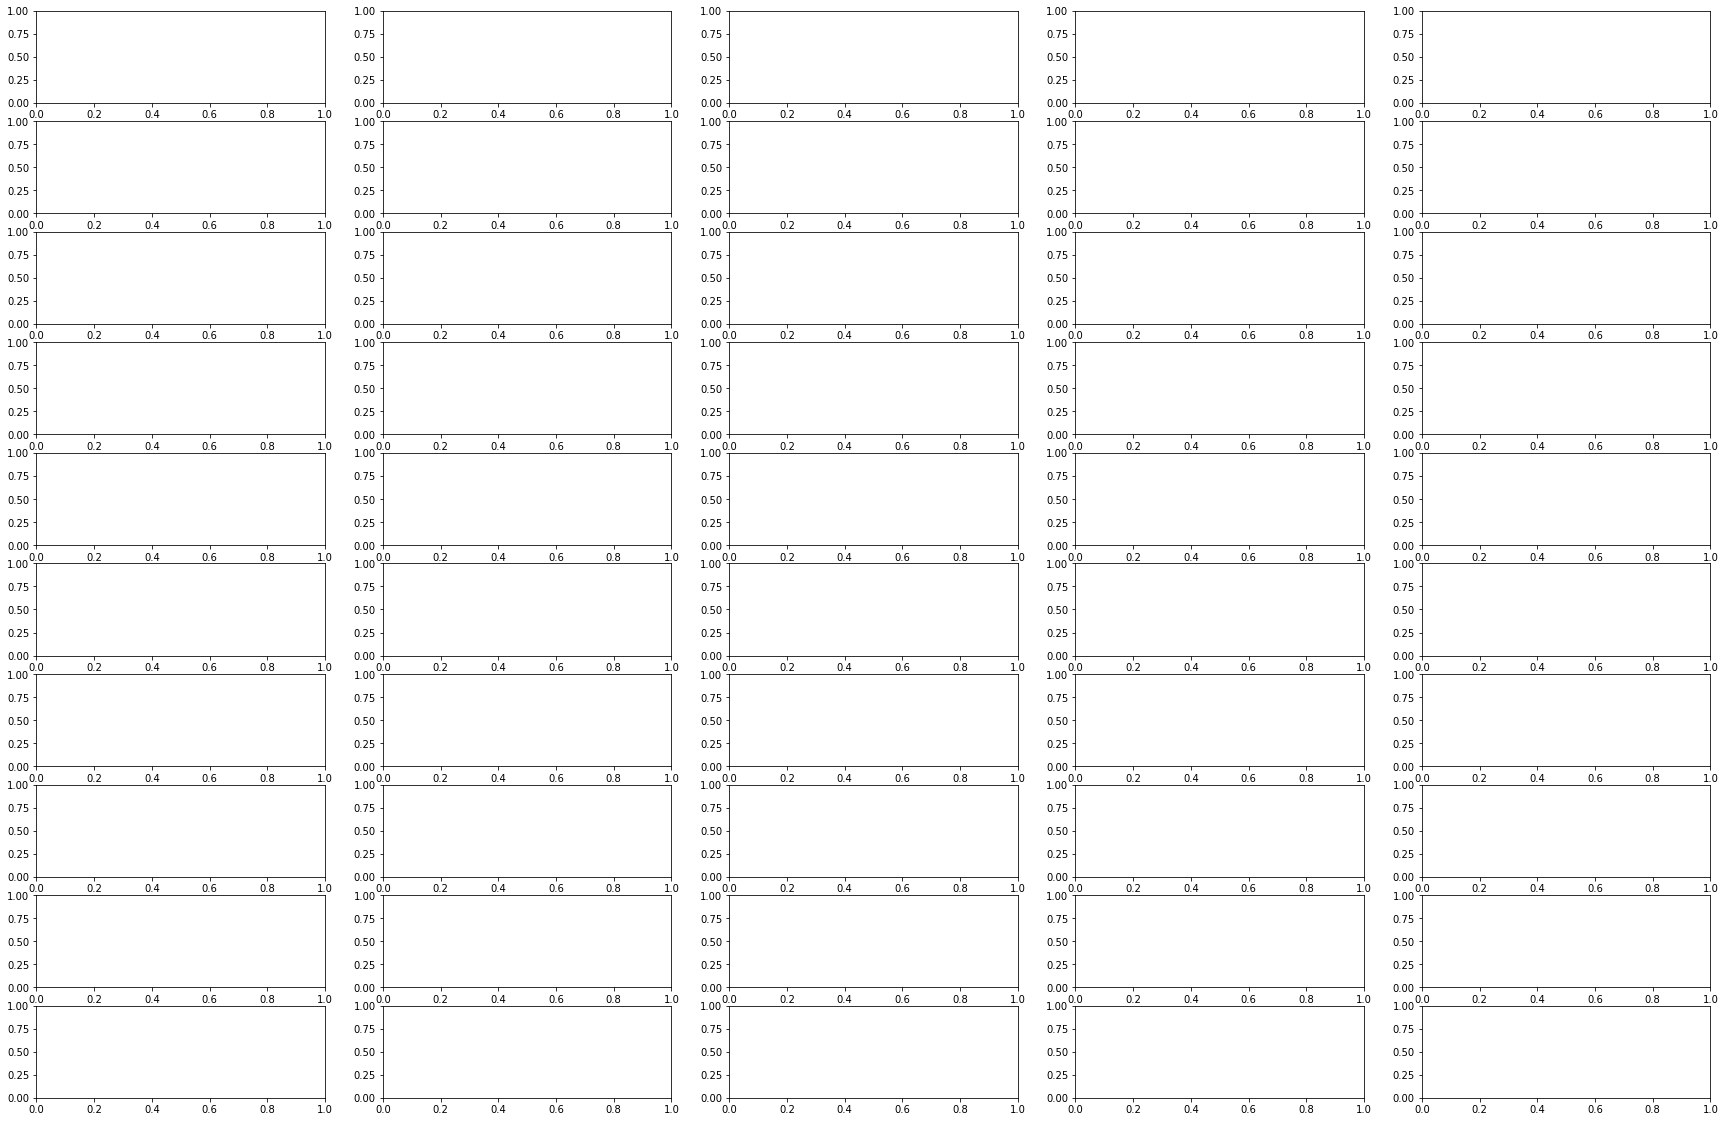

In [48]:
plot_filters(W_conv, 5, figsize=(30,20))

In [33]:
import keras.backend as K


def input_grad(model, x, layer_idx=-2):
    """Get the gradient of model output (before the final activation layer) w.r.t. model input
    
    Args:
      model: Sequence-based keras model
      x: one-hot-encoded DNA sequence
      layer_idx: output layer index
    """
    fn = K.function([model.input], K.gradients(model.layers[layer_idx].output, [model.input]))
    return fn([x])[0]


def plot_seq_importance(model, x, xlim=None, layer_idx=-2, figsize=(25, 3)):
    """Plot input x gradient sequence importance score
    
    Args:
      model: DNA-sequence based Sequential keras model
      x: one-hot encoded DNA sequence
      xlim: restrict the plotted xrange
      figsize: matplotlib figure size
    """
    seq_len = x.shape[1]
    if xlim is None:
        xlim = (0, seq_len)
    grads = input_grad(model, x, layer_idx=layer_idx)
    for i in range(len(x)):
        seqlogo_fig(grads[i]*x[i], figsize=figsize)
        plt.xticks(list(range(xlim[0], xlim[1], 5)))
        plt.xlim(xlim)

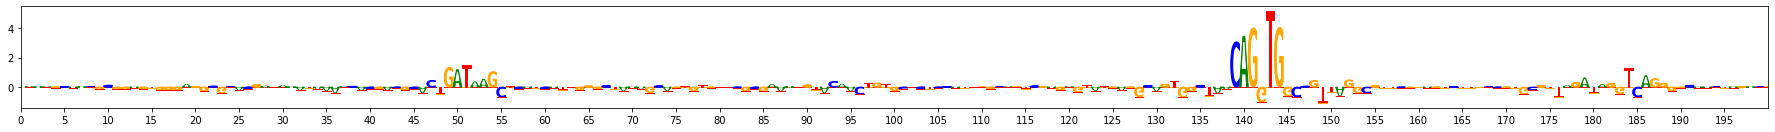

In [49]:
# plot_seq_importance(model, X_test[:1], xlim=(250, 350), figsize=(25, 2))
plot_seq_importance(model1, X_test_premade[:1], figsize=(25, 2))

fake seq


In [24]:
!zcat sequences.simdata.gz | head

seqName	sequence	embeddings	task1	task2	task3
empty_1732	AGCTCTTTTGGCGGACCGAGTTCGTCGGACTTTCGCTAAATTGACCATTAACAGGAGGATACCCGGGTGTCTCGGGAAGGTCGTAATACGGTAATTACGGATGTGAGAGCGCACACATCCTTTGGATGATACATGATCTCGCCGTATATGGCCTAGGTCAAAAGGACAGTCTCGCTAATCGCAATAATGCAGCTAACCGA		0	0	0
gata_only_1527	TGCAGATAAGAACTTTGGGAATATGGTAGGAAAAACCCCTGAAGTGAGATCCAAAAAATATAGACTGGCGCGGTGGCAATGCCCTTGTTAATGCTGGGAATCAAAAAATCGAAACTCTCAGCAGATAAGATATGCAGACCTGCTCGTGGAGACAAAAAGTATTGTTACTGCGTAAACCATTAGTACGTTGCCGAGTACCG	pos-120_GATA_disc1-GCAGATAAGA,pos-1_GATA_disc1-GCAGATAAGA	0	1	0
gata_tal1_62	AGATTATAGGCCCTCCACCAGATAAGATATAGCGTTCGAGGGTCAGAAGGTAGTTCTGAAGATCTCTTCATTGTGAAAGGCCTCATATGATGAGCTTCTCCATTCTCAGCTGACAGGCAAAACAATTGATCAGCGCTTAGGCGCCAGATGTTTACTCCCGTTAAGTCAACTTAGCTGTGTTCGTCAAATCCGCAACGCGG	pos-17_GATA_disc1-CCAGATAAGA,pos-139_TAL1_known1-GGCGCCAGATGTTTAC	1	1	1
empty_1289	TTTGGGCGCGGAAGAAGTCGCTCGCCTTTCTGTACTTGAAAATGATTACATGTAAGGATGTAACTCAATCGCAACATTGTCATTGGGTTCCATCGCCCTAGCGGTAGTAGGTTTTACCTCCAACTTGACAACCCTTCGTAAATATAAAATAGTAGTAA

In [10]:
embedInBackground = sn.EmbedInABackground(
        backgroundGenerator=sn.ZeroOrderBackgroundGenerator(seqLength=4), embedders=[]
    )
sequenceSet = sn.GenerateSequenceNTimes(embedInBackground, 4)
sn.printSequences("./trash"+".simdata", sequenceSet, includeFasta=True, includeEmbeddings=True,
                      prefix="empty"

In [6]:
!emptyBackground.py --seqLength 500 --numSeqs 1000 #bg

In [33]:
!motifGrammarSimulation.py --motifName1 SIX5_disc1 --motifName2 NFY_disc1 --seqLength 500 --numSeq 500 --generationSetting twoMotifsVariableSpacing --fixedSpacingOrMinSpacing 1 --maxSpacing 5

In [9]:
multi_motif_parameters = {
    "motif_names": ["CTCF_known1","ZNF143_known2","SIX5_known1"],
    "seq_length": 500,
    "min_num_motifs": 0,
    "max_num_motifs": 1, 
    "num_seqs": 20000,
    "GC_fraction": 0.4}

#Get simulation data
multi_motif_data=get_simulation_data("simulate_multi_motif_embedding",
                               multi_motif_parameters,
                               validation_set_size=3200,test_set_size=4000)

In [32]:
# ! head /content/EmptyBackground_seqLength-500_numSeqs-200.simdata
! head /content/motifGrammarSimulation_twoMotifsVariableSpacing_motif1-TAL1_known1_motif2-NFY_disc1_seqLength200_numSeq10.simdata

seqName	sequence	embeddings
synthPos0	ATTACCGTAATCTACTATTAAGTCACAACCAAACAATGGATTACTTTCTGCGTTGGAATCAGTGCCGTGCCAATTGCTACGACAGTTGGTCCGTTTTGTGATTCACACGGGCAAAGTTTTATGAAATAAGCAAGAATCCCACCAATGAGTAAATATGGATTGAGCGCGAATTCTCTTCAATATTGATTTGCCAGCAAGAC	pos-77_TAL1_known1-TACGACAGTTGGTCCG,pos-98_GATA_disc2-TGATTCACAC,pos-77_TAL1_known1-TACGACAGTTGGTCCG-Gap5-GATA_disc2-TGATTCACAC
synthPos1	ATTAGAATAATCAAATATCTTAACAGAATAGCCATTTAAGTGGGAGCAAATCGGTCCCCTTCCGGGAAATAGACCAGATGTTCTGTTTGATTCACACTTTTTGACATGAATTGGTCCCAAGCGACAAATCCGAAGGGCGTACCACGTTAGAAGTATTCGTCTTGTTTGAAAGTAGTCGATATTGATTATTGTCTTCTCAC	pos-69_TAL1_known1-TAGACCAGATGTTCTG,pos-87_GATA_disc2-TGATTCACAC,pos-69_TAL1_known1-TAGACCAGATGTTCTG-Gap2-GATA_disc2-TGATTCACAC
synthPos2	TGCGCAAAGTTGTCTCTTCAGGCACCCTGTTTCTGGGCGGTTTTTGCATTGATCCAGTCCGAGTGCGGAATAATGCCTGCCCAGATGGCGAATTATTGATTCACTATTGAGAATCTATTCACCAAAGTAATTTGCTAGACCCAATCGATCGTTATTCCGTCTTATAAGACACTTAATAAAAAGTGTGCGTGAATGCGGGA	pos-76_TAL1_known1-CTGCCCAGATGGCGAA,pos-96_GATA_disc2-TGATTCACTA,pos-76_TAL1_known1

In [44]:
!densityMotifSimulation.py  --motifNames GATA_disc1 SIX5_known1 TAL1_known1 --mean-motifs 1 --max-motifs 2 --min-motifs 1  --seqLength 200 --numSeqs 100 
#--mean-motifs 2

In [45]:
!head  -50 /content/DensityEmbedding_motifs-GATA_disc1+SIX5_known1+TAL1_known1_min-1_max-2_mean-1_zeroProb-0_seqLength-200_numSeqs-100.simdata

seqName	sequence	embeddings
synth0	ATGTATGGATATCAATTATAAGTCACAACCAATCTGATTAGAACTTTCTGCGTGCCATCAGATGGTCGACCAATTGCAGTTGTAGTGCAGTATTTTTGGCATGAGCCCGGGCAATACGGGTATCACCATACAAGAATCCCACCAATGAGTAAATATGGATTGAGCGCGAATTCTCTTCCCGTCCAGGTGTTGCGCAAGAC	pos-32_GATA_disc1-TCTGATTAGA,pos-2_SIX5_known1-GTATGGATATCAATTAT,pos-113_SIX5_known1-ATACGGGTATCACCATA,pos-53_TAL1_known1-GCCATCAGATGGTCGA,pos-178_TAL1_known1-CCGTCCAGGTGTTGCG
synth1	TGGTCCCAAGCGACAAATCCGAAGGGCGTACCCATGATAAGGTATTCGTCTTGTTTGAAAGTAGTCTGGGGGGTATCACTCATTCTCACATTAGCAAATAACAGGTAAGAGAGTTTGCTTGCAATATGTTTAGCGAACAGATGGTCCAAAAGTTGTCTCTTCAGGCACCCTGTTTCTGGGCGGTTTTTGCATTGATCCAG	pos-32_GATA_disc1-CATGATAAGG,pos-66_SIX5_known1-TGGGGGGTATCACTCAT,pos-132_TAL1_known1-GCGAACAGATGGTCCA
synth2	CGTTGAGTGGTATCATTCAGCACTTAATAAAAAGTGTGCCGCACCAGGTGGTTCGCGTTTTACAGTACAGATGGTGACTTAGATAACTCATTTCCAGCCTCGAGATAAGGTTAACGACGATGCACCTGGATCCATCTTTTTTTAGGTTTTCTGCCTGAAGGTACTAAGAAAGGAAGTCGGGTATCACTTCCTTTTTAATT	pos-100_GATA_disc1-CGAGATAAGG,pos-3_SIX5_known1-TGAGTGGTATCATTCAG,pos

In [23]:
!head /content/DensityEmbedding_prefix-gata_motifs-GATA_disc1+SIX5_known1_min-1_max-3_mean-2_zeroProb-0.5_seqLength-200_numSeqs-10.simdata

seqName	sequence	embeddings
gata-synth0	ATTACCGTAATCTACTATTAATAGGGTATCACATTGTGGATTACTTTCTGCGTTGGAATCAGTGCCGTGCCAATTGCAGTTGTAGTGCAGTATTTTTGGCATGAGCCCGGGCAAAGTTTTAGGAGGTCTCATGCAGTCCCACCAATGAGTAAATATGGATTGAGCGCATAGGGGTATCAATAAAGATTTGCCAGCAAGAC	pos-19_SIX5_known1-AATAGGGTATCACATTG,pos-167_SIX5_known1-ATAGGGGTATCAATAAA,pos-119_SIX5_known1-TAGGAGGTCTCATGCAG
gata-synth1	GTCCCCTTCCGGGAAAAGAAGATCTAGTATATTTCAGTATATACTTTTTGACATGAATTGGTCCCAAGCGACAAATCCGAAACGAGGGTATCAGCTGTAGTATTCGTCTTGTTTGAAAGGAAGGTGTATCACGTCTTGTCTTCTCACATTAGCAAATAACAGGCGTGGGGTATCAATGGCAATATGTTTAGGCGCGACCC	pos-119_SIX5_known1-GAAGGTGTATCACGTCT,pos-163_SIX5_known1-CGTGGGGTATCAATGGC,pos-81_SIX5_known1-ACGAGGGTATCAGCTGT
gata-synth2	TTGAGAATCTATTCACCAAAGTAATTTGCTAGACCCAATCGATCGTTATTCCGTCTTATAAGACACTTAATAAAAAGTGTGCGTGAATGCGGGACCATCGTTTTATATTTAATCCTAGCACTTAGATAACTCATTTCCAGCCTTGAGCTTTTGTTAACGACGATGCACCTGGATCCATCTTTTTTTAGGTTTTCTGCCTG	
gata-synth3	GGTACTAAGAAAGGAATGATACTTATGTTCGGTTTTTAATTGCCTTGATCAAGAACTTTGGGTCAGGGATATCACATATCCTTGTTTCCTCTCC

In [34]:
!zcat sequences.simdata.gz | head -20

seqName	sequence	embeddings	task1	task2	task3
empty_1732	AGCTCTTTTGGCGGACCGAGTTCGTCGGACTTTCGCTAAATTGACCATTAACAGGAGGATACCCGGGTGTCTCGGGAAGGTCGTAATACGGTAATTACGGATGTGAGAGCGCACACATCCTTTGGATGATACATGATCTCGCCGTATATGGCCTAGGTCAAAAGGACAGTCTCGCTAATCGCAATAATGCAGCTAACCGA		0	0	0
gata_only_1527	TGCAGATAAGAACTTTGGGAATATGGTAGGAAAAACCCCTGAAGTGAGATCCAAAAAATATAGACTGGCGCGGTGGCAATGCCCTTGTTAATGCTGGGAATCAAAAAATCGAAACTCTCAGCAGATAAGATATGCAGACCTGCTCGTGGAGACAAAAAGTATTGTTACTGCGTAAACCATTAGTACGTTGCCGAGTACCG	pos-120_GATA_disc1-GCAGATAAGA,pos-1_GATA_disc1-GCAGATAAGA	0	1	0
gata_tal1_62	AGATTATAGGCCCTCCACCAGATAAGATATAGCGTTCGAGGGTCAGAAGGTAGTTCTGAAGATCTCTTCATTGTGAAAGGCCTCATATGATGAGCTTCTCCATTCTCAGCTGACAGGCAAAACAATTGATCAGCGCTTAGGCGCCAGATGTTTACTCCCGTTAAGTCAACTTAGCTGTGTTCGTCAAATCCGCAACGCGG	pos-17_GATA_disc1-CCAGATAAGA,pos-139_TAL1_known1-GGCGCCAGATGTTTAC	1	1	1
empty_1289	TTTGGGCGCGGAAGAAGTCGCTCGCCTTTCTGTACTTGAAAATGATTACATGTAAGGATGTAACTCAATCGCAACATTGTCATTGGGTTCCATCGCCCTAGCGGTAGTAGGTTTTACCTCCAACTTGACAACCCTTCGTAAATATAAAATAGTAGTAA